In [613]:
"""
October 2019
Author: Joel Pires
"""
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import missingno
import scipy.stats as st
import warnings
import pickle
import scikit_posthocs as sp
import imgkit
import os
import cufflinks as cf
import copy
import dython.nominal as nominal
import itertools
import joblib

from collections import deque
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel
from sklearn.manifold import TSNE, LocallyLinearEmbedding
from scipy.special import boxcox1p
from matplotlib.gridspec import GridSpec
from eli5 import show_weights
from eli5.sklearn import PermutationImportance
from shutil import copyfile
from plotly.offline import init_notebook_mode, iplot
from pathlib import Path
from collections import Counter
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder, KBinsDiscretizer
from sklearn.metrics import *
from sklearn.decomposition import PCA, KernelPCA
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve, train_test_split, cross_val_score, cross_validate, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.tree._tree import TREE_LEAF
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# classifiers evaluated
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import BaggingRegressor
from vecstack import stacking
from mlens.ensemble import BlendEnsemble

%matplotlib inline
warnings.filterwarnings('ignore')

In [614]:
#Load Data
df = pd.read_csv('./data/house_prices/train.csv')

df.drop(['Id'], axis=1, inplace=True)

In [615]:
all_cols = df.columns
numerical = list(df._get_numeric_data().columns)
categorical = list(set(all_cols) - set(numerical))
del numerical[numerical.index("SalePrice")]

#reorder dataframe columns for later better tracking of the features once encoded
original_order = df.columns[:-1].tolist()
new_order = numerical + categorical
total = new_order + ['SalePrice']
df = df[total]

# **EXPLORATORY ANALYSIS**

In [616]:
# Preview Data
display(df.shape)
df.head()


(1460, 80)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Street,FireplaceQu,RoofStyle,Exterior2nd,GarageCond,LandSlope,KitchenQual,Functional,CentralAir,Exterior1st,Fence,MiscFeature,Condition1,MasVnrType,HouseStyle,MSZoning,LotShape,Condition2,GarageFinish,GarageQual,SaleCondition,Alley,LotConfig,LandContour,Foundation,RoofMatl,PoolQC,BsmtFinType2,Heating,Neighborhood,BsmtQual,PavedDrive,SaleType,BsmtExposure,HeatingQC,BsmtFinType1,Electrical,Utilities,ExterCond,ExterQual,BsmtCond,BldgType,GarageType,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008,Pave,NaN,Gable,VinylSd,TA,Gtl,Gd,Typ,Y,VinylSd,NaN,NaN,Norm,BrkFace,2Story,RL,Reg,Norm,RFn,TA,Normal,NaN,Inside,Lvl,PConc,CompShg,NaN,Unf,GasA,CollgCr,Gd,Y,WD,No,Ex,GLQ,SBrkr,AllPub,TA,Gd,TA,1Fam,Attchd,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007,Pave,TA,Gable,MetalSd,TA,Gtl,TA,Typ,Y,MetalSd,NaN,NaN,Feedr,None,1Story,RL,Reg,Norm,RFn,TA,Normal,NaN,FR2,Lvl,CBlock,CompShg,NaN,Unf,GasA,Veenker,Gd,Y,WD,Gd,Ex,ALQ,SBrkr,AllPub,TA,TA,TA,1Fam,Attchd,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008,Pave,TA,Gable,VinylSd,TA,Gtl,Gd,Typ,Y,VinylSd,NaN,NaN,Norm,BrkFace,2Story,RL,IR1,Norm,RFn,TA,Normal,NaN,Inside,Lvl,PConc,CompShg,NaN,Unf,GasA,CollgCr,Gd,Y,WD,Mn,Ex,GLQ,SBrkr,AllPub,TA,Gd,TA,1Fam,Attchd,223500
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006,Pave,Gd,Gable,Wd Shng,TA,Gtl,Gd,Typ,Y,Wd Sdng,NaN,NaN,Norm,None,2Story,RL,IR1,Norm,Unf,TA,Abnorml,NaN,Corner,Lvl,BrkTil,CompShg,NaN,Unf,GasA,Crawfor,TA,Y,WD,No,Gd,ALQ,SBrkr,AllPub,TA,TA,Gd,1Fam,Detchd,140000
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008,Pave,TA,Gable,VinylSd,TA,Gtl,Gd,Typ,Y,VinylSd,NaN,NaN,Norm,BrkFace,2Story,RL,IR1,Norm,RFn,TA,Normal,NaN,FR2,Lvl,PConc,CompShg,NaN,Unf,GasA,NoRidge,Gd,Y,WD,Av,Ex,GLQ,SBrkr,AllPub,TA,Gd,TA,1Fam,Attchd,250000


In [617]:
df.tail()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Street,FireplaceQu,RoofStyle,Exterior2nd,GarageCond,LandSlope,KitchenQual,Functional,CentralAir,Exterior1st,Fence,MiscFeature,Condition1,MasVnrType,HouseStyle,MSZoning,LotShape,Condition2,GarageFinish,GarageQual,SaleCondition,Alley,LotConfig,LandContour,Foundation,RoofMatl,PoolQC,BsmtFinType2,Heating,Neighborhood,BsmtQual,PavedDrive,SaleType,BsmtExposure,HeatingQC,BsmtFinType1,Electrical,Utilities,ExterCond,ExterQual,BsmtCond,BldgType,GarageType,SalePrice
1455,60,62.0,7917,6,5,1999,2000,0.0,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,1999.0,2,460,0,40,0,0,0,0,0,8,2007,Pave,TA,Gable,VinylSd,TA,Gtl,TA,Typ,Y,VinylSd,NaN,NaN,Norm,None,2Story,RL,Reg,Norm,RFn,TA,Normal,NaN,Inside,Lvl,PConc,CompShg,NaN,Unf,GasA,Gilbert,Gd,Y,WD,No,Ex,Unf,SBrkr,AllPub,TA,TA,TA,1Fam,Attchd,175000
1456,20,85.0,13175,6,6,1978,1988,119.0,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,1978.0,2,500,349,0,0,0,0,0,0,2,2010,Pave,TA,Gable,Plywood,TA,Gtl,TA,Min1,Y,Plywood,MnPrv,NaN,Norm,Stone,1Story,RL,Reg,Norm,Unf,TA,Normal,NaN,Inside,Lvl,CBlock,CompShg,NaN,Rec,GasA,NWAmes,Gd,Y,WD,No,TA,ALQ,SBrkr,AllPub,TA,TA,TA,1Fam,Attchd,210000
1457,70,66.0,9042,7,9,1941,2006,0.0,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1941.0,1,252,0,60,0,0,0,0,2500,5,2010,Pave,Gd,Gable,CmentBd,TA,Gtl,Gd,Typ,Y,CemntBd,GdPrv,Shed,Norm,None,2Story,RL,Reg,Norm,RFn,TA,Normal,NaN,Inside,Lvl,Stone,CompShg,NaN,Unf,GasA,Crawfor,TA,Y,WD,No,Ex,GLQ,SBrkr,AllPub,Gd,Ex,Gd,1Fam,Attchd,266500
1458,20,68.0,9717,5,6,1950,1996,0.0,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1950.0,1,240,366,0,112,0,0,0,0,4,2010,Pave,NaN,Hip,MetalSd,TA,Gtl,Gd,Typ,Y,MetalSd,NaN,NaN,Norm,None,1Story,RL,Reg,Norm,Unf,TA,Normal,NaN,Inside,Lvl,CBlock,CompShg,NaN,Rec,GasA,NAmes,TA,Y,WD,Mn,Gd,GLQ,FuseA,AllPub,TA,TA,TA,1Fam,Attchd,142125
1459,20,75.0,9937,5,6,1965,1965,0.0,830,290,136,1256,1256,0,0,1256,1,0,1,1,3,1,6,0,1965.0,1,276,736,68,0,0,0,0,0,6,2008,Pave,NaN,Gable,HdBoard,TA,Gtl,TA,Typ,Y,HdBoard,NaN,NaN,Norm,None,1Story,RL,Reg,Norm,Fin,TA,Normal,NaN,Inside,Lvl,CBlock,CompShg,NaN,LwQ,GasA,Edwards,TA,Y,WD,No,Gd,BLQ,SBrkr,AllPub,TA,Gd,TA,1Fam,Attchd,147500


In [618]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
MasVnrArea       1452 non-null float64
BsmtFinSF1       1460 non-null int64
BsmtFinSF2       1460 non-null int64
BsmtUnfSF        1460 non-null int64
TotalBsmtSF      1460 non-null int64
1stFlrSF         1460 non-null int64
2ndFlrSF         1460 non-null int64
LowQualFinSF     1460 non-null int64
GrLivArea        1460 non-null int64
BsmtFullBath     1460 non-null int64
BsmtHalfBath     1460 non-null int64
FullBath         1460 non-null int64
HalfBath         1460 non-null int64
BedroomAbvGr     1460 non-null int64
KitchenAbvGr     1460 non-null int64
TotRmsAbvGrd     1460 non-null int64
Fireplaces       1460 non-null int64
G

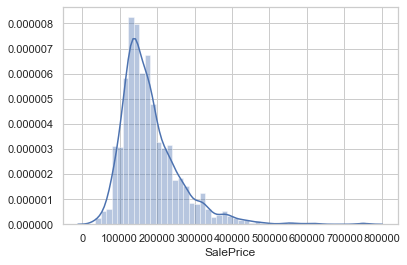

In [619]:
#Example of univariate exploration of the distribution of a variable, in this case - the target
sns.distplot(df['SalePrice']);

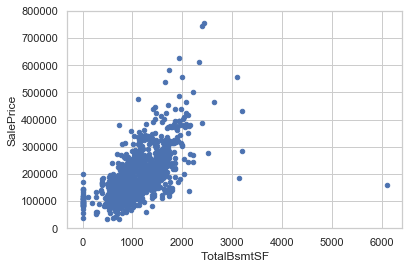

In [620]:
#Scatterint a feature in relation to the target
var = 'TotalBsmtSF'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

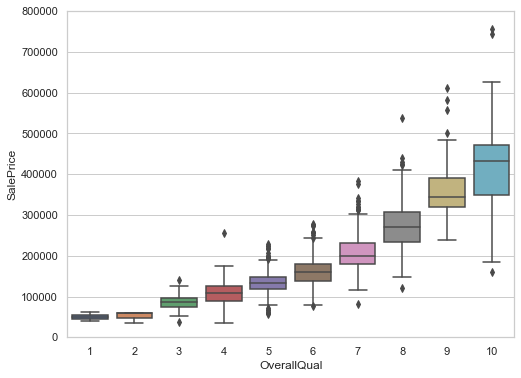

In [621]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

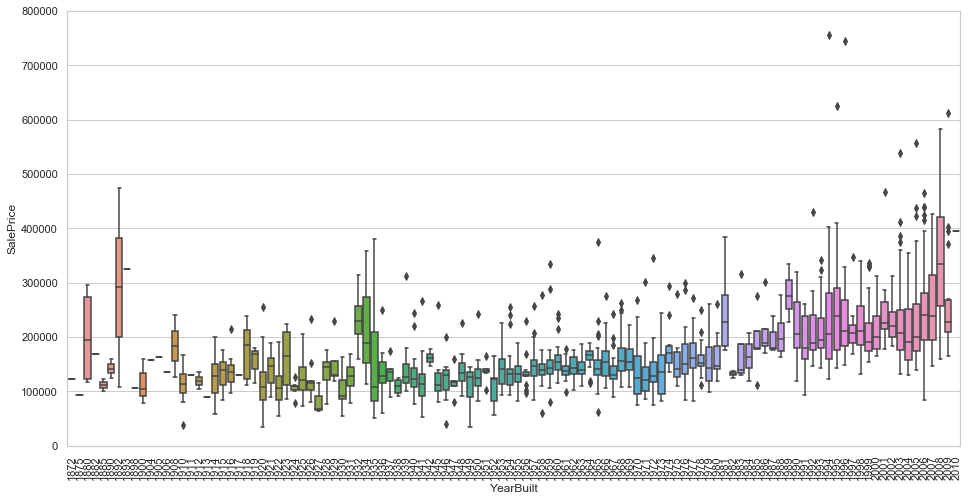

In [622]:
#These boxplot would be way better with bins - TODO
var = 'YearBuilt'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

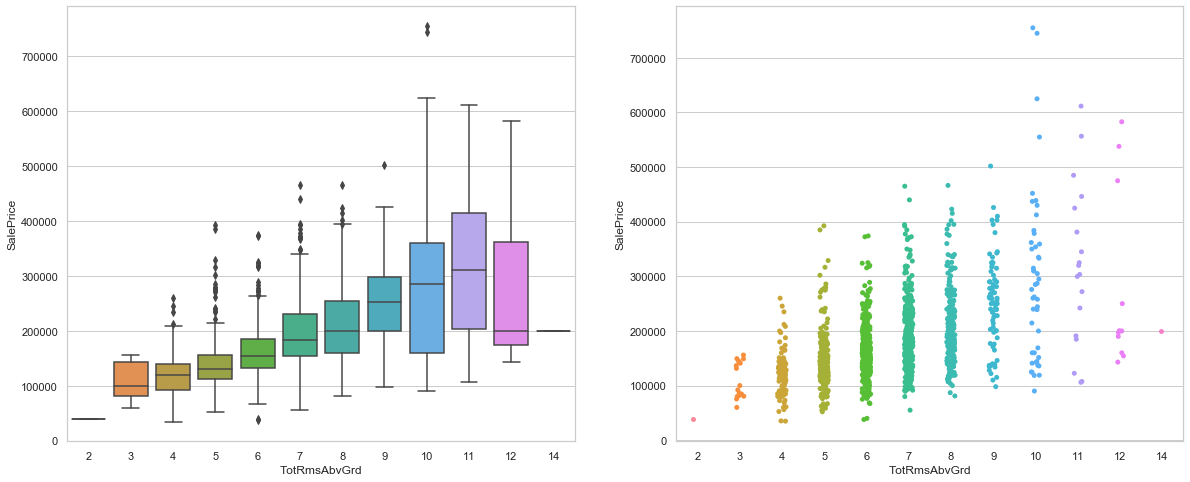

In [623]:
feature = "TotRmsAbvGrd"
rotation1 = 0
rotation2 = 0

fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,0]))
plt.xticks(rotation = rotation1)
sns.stripplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,1]))
plt.xticks(rotation = rotation2)
fig.show()

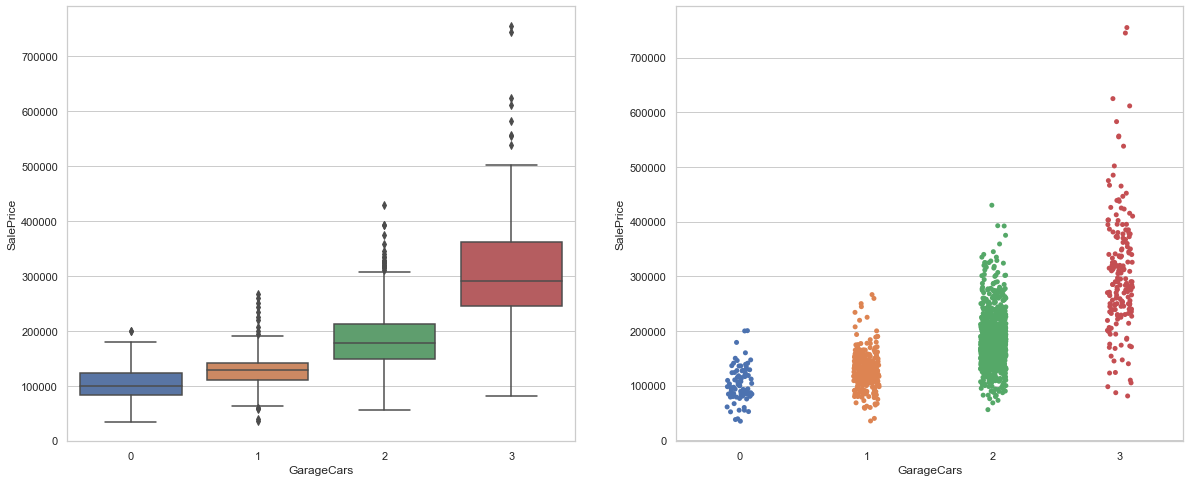

In [624]:
feature = "GarageCars"
rotation1 = 0
rotation2 = 0


df.GarageCars = df.GarageCars.apply(lambda x: 3 if x>3 else x)

fig = plt.figure(figsize=(20,8))
gs = GridSpec(1,2)
sns.boxplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,0]))
plt.xticks(rotation = rotation1)
sns.stripplot(y=df['SalePrice'], x=df[feature], ax=fig.add_subplot(gs[0,1]))
plt.xticks(rotation = rotation2)
fig.show()

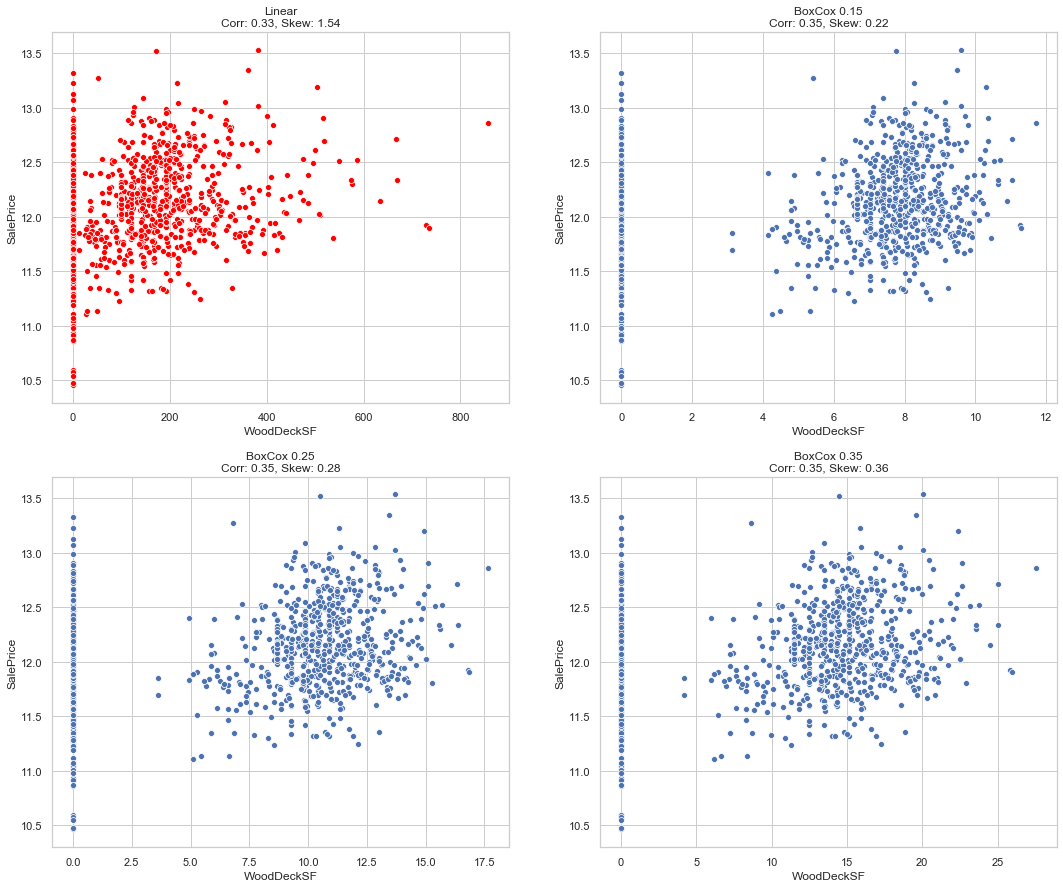

In [625]:
feature = 'WoodDeckSF'

    
fig = plt.figure(figsize=(18,15))
gs = GridSpec(2,2)
    
j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                    x=boxcox1p(df[feature], 0.15), ax=fig.add_subplot(gs[0,1]), palette = 'blue')

plt.title('BoxCox 0.15\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(boxcox1p(df[feature], 0.15)),2)) + ', Skew: ' +
           str(np.round(st.skew(boxcox1p(df[feature], 0.15)),2)))

j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                    x=boxcox1p(df[feature], 0.25), ax=fig.add_subplot(gs[1,0]), palette = 'blue')

plt.title('BoxCox 0.25\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(boxcox1p(df[feature], 0.25)),2)) + ', Skew: ' +
           str(np.round(st.skew(boxcox1p(df[feature], 0.25)),2)))

j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                    x=boxcox1p(df[feature], 0.35), ax=fig.add_subplot(gs[1,1]), palette = 'blue')

plt.title('BoxCox 0.35\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(boxcox1p(df[feature], 0.35)),2)) + ', Skew: ' +
           str(np.round(st.skew(boxcox1p(df[feature], 0.35)),2)))

j = sns.scatterplot(y=np.log1p(df['SalePrice']), 
                    x=df[feature], ax=fig.add_subplot(gs[0,0]), color = 'red')

plt.title('Linear\n' + 'Corr: ' + str(np.round(np.log1p(df['SalePrice']).corr(df[feature]),2)) + ', Skew: ' + 
           str(np.round(st.skew(df[feature]),2)))

fig.show()

# Data Pre-Processing


## Nonsense values
Negative Values, etc

In [626]:
pd.set_option('display.max_columns', 100)
for col in df:
    print(col)
    print (df[col].unique())
    print('\n')


MSSubClass
[ 60  20  70  50 190  45  90 120  30  85  80 160  75 180  40]


LotFrontage
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]


LotArea
[ 8450  9600 11250 ... 17217 13175  9717]


OverallQual
[ 7  6  8  5  9  4 10  3  1  2]


OverallCond
[5 8 6 7 4 2 3 9 1]


YearBuilt
[2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 19

In [627]:
display(df.describe(include = 'all')) #it helps to understand non-sense values

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,Street,FireplaceQu,RoofStyle,Exterior2nd,GarageCond,LandSlope,KitchenQual,Functional,CentralAir,Exterior1st,Fence,MiscFeature,Condition1,MasVnrType,HouseStyle,MSZoning,LotShape,Condition2,GarageFinish,GarageQual,SaleCondition,Alley,LotConfig,LandContour,Foundation,RoofMatl,PoolQC,BsmtFinType2,Heating,Neighborhood,BsmtQual,PavedDrive,SaleType,BsmtExposure,HeatingQC,BsmtFinType1,Electrical,Utilities,ExterCond,ExterQual,BsmtCond,BldgType,GarageType,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460,770,1460,1460,1379,1460,1460,1460,1460,1460,281,54,1460,1452,1460,1460,1460,1460,1379,1379,1460,91,1460,1460,1460,1460,7,1422,1460,1460,1423,1460,1460,1422,1460,1423,1459,1460,1460,1460,1423,1460,1379,1460.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,5,6,16,5,3,4,7,2,15,4,4,9,4,8,5,4,8,3,5,6,2,5,4,6,8,3,6,6,25,4,3,9,4,5,6,5,2,5,4,4,5,6,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pave,Gd,Gable,VinylSd,TA,Gtl,TA,Typ,Y,VinylSd,MnPrv,Shed,Norm,None,1Story,RL,Reg,Norm,Unf,TA,Normal,Grvl,Inside,Lvl,PConc,CompShg,Gd,Unf,GasA,NAmes,TA,Y,WD,No,Ex,Unf,SBrkr,AllPub,TA,TA,TA,1Fam,Attchd,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1454,380,1141,504,1326,1382,735,1360,1365,515,157,49,1260,864,726,1151,925,1445,605,1311,1198,50,1052,1311,647,1434,3,1256,1428,225,649,1340,1267,953,741,430,1334,1459,1282,906,1311,1220,870,NaN
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.763699,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.739318,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## Missing Values


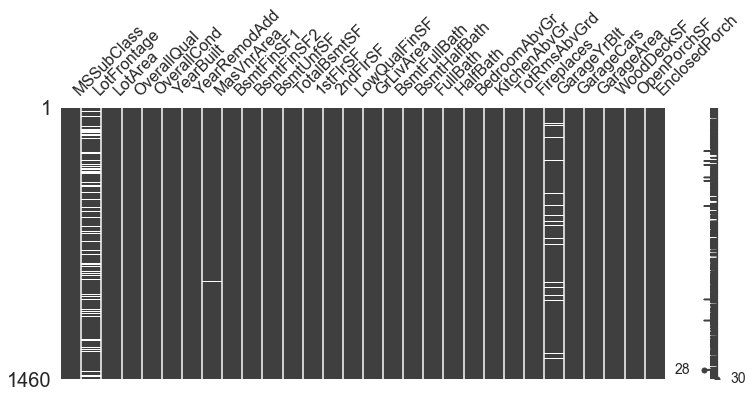

In [628]:
missingno.matrix(df.iloc[:,0:30], figsize=(12, 5))

In [629]:
df.isnull().sum()

MSSubClass       0
LotFrontage    259
LotArea          0
OverallQual      0
OverallCond      0
              ... 
ExterQual        0
BsmtCond        37
BldgType         0
GarageType      81
SalePrice        0
Length: 80, dtype: int64

In [630]:
columns = df.columns

imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=False)
df = pd.DataFrame(imputer.fit_transform(df))

df.columns = columns 

#droping features with more than 85% missing features
#df = df.dropna(thresh=len(df)*0.85, axis=1)

#total = df.isnull().sum().sort_values(ascending=False)
#percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
#missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#df = df.drop((missing_data[missing_data['Total'] > 1]).index,1)
#df = df.drop(df.loc[df['Electrical'].isnull()].index)


"""  

for col in df.columns:
    df[col].fillna(df[col].mode(), inplace=True)


#fill the NaN values with the mode. It could be filled with median, mean, etc
for col in df.columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

#we could fill every missing values with medians of the columns
#df = data.fillna(df.median())

#also, instead of fill, we can remove every row in which 10% of the values are missing
# df = df.loc[df.isnull().mean(axis=1) < 0.1]    
"""
"""
#It is possible to use an imputer. and fill with the values of median, mean, etc
#If imputation technique is used, it is a good practice to add an additional binary feature as a missing indicator.
imputer = SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=True)
imputer = SimpleImputer(strategy='mean')
imputer = SimpleImputer(strategy='median')
imputer = SimpleImputer(strategy='constant')
df = pd.DataFrame(imputer.fit_transform(df))
"""

"""
# It is also possible to run a bivariate imputer (iterative imputer). However, it is needed to do labelencoding first. The code below enables us to run the imputer with a Random Forest estimator
# The Iterative Imputer is developed by Scikit-Learn and models each feature with missing values as a function of other features. It uses that as an estimate for imputation. At each step, a feature is selected as output y and all other features are treated as inputs X. A regressor is then fitted on X and y and used to predict the missing values of y. This is done for each feature and repeated for several imputation rounds.
# The great thing about this method is that it allows you to use an estimator of your choosing. I used a RandomForestRegressor to mimic the behavior of the frequently used missForest in R.
imp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)
df = pd.DataFrame(imp.fit_transform(df), columns=df.columns)

#If you have sufficient data, then it might be an attractive option to simply delete samples with missing data. However, keep in mind that it could create bias in your data. Perhaps the missing data follows a pattern that you miss out on.

#The Iterative Imputer allows for different estimators to be used. After some testing, I found out that you can even use Catboost as an estimator! Unfortunately, LightGBM and XGBoost do not work since their random state names differ.
"""

'\n# It is also possible to run a bivariate imputer (iterative imputer). However, it is needed to do labelencoding first. The code below enables us to run the imputer with a Random Forest estimator\n# The Iterative Imputer is developed by Scikit-Learn and models each feature with missing values as a function of other features. It uses that as an estimate for imputation. At each step, a feature is selected as output y and all other features are treated as inputs X. A regressor is then fitted on X and y and used to predict the missing values of y. This is done for each feature and repeated for several imputation rounds.\n# The great thing about this method is that it allows you to use an estimator of your choosing. I used a RandomForestRegressor to mimic the behavior of the frequently used missForest in R.\nimp = IterativeImputer(RandomForestRegressor(), max_iter=10, random_state=0)\ndf = pd.DataFrame(imp.fit_transform(df), columns=df.columns)\n\n#If you have sufficient data, then it mig

In [631]:
display(df.isnull().sum())

MSSubClass     0
LotFrontage    0
LotArea        0
OverallQual    0
OverallCond    0
              ..
ExterQual      0
BsmtCond       0
BldgType       0
GarageType     0
SalePrice      0
Length: 80, dtype: int64

(more examples of operations for replacing values if needed in the future)

In [632]:
"""
#Replace specific values if needed
Replace symbol in whole column
df['age'] = df['age'].str.replace('–', '**', regex = True)


#DROP multiple columns
df.drop(['age' , 'fnlwgt'], axis = 1, inplace = True)


#Find text with regex and replace with nothing
 df = df.replace({
     'age':'[A-Za-z]', 
     'fnlwgt': '[A-Za-z]',
 },'',regex = True)


#Example of applying a formula to entire column

 def euro(cell):
     cell = cell.strip('€')
     return cell
 df.Wage = df.Wage.apply(euro)

#Insert value in cell depending on values from other cells
 def impute_age(cols):
     age = cols[0]
     Pclass = cols[1]
     if pd.isnull(Age):
         if Pclass == 1:
             return 37
         else:
             return 24
     else:
         return Age
         
#CHANGING DATA TYPES
#changing values to float
df[['Value','Wage','Age']].apply(pd.to_numeric, errors = 'coerce')
df.column.astype(float)
df.dtypes
"""

"\n#Replace specific values if needed\nReplace symbol in whole column\ndf['age'] = df['age'].str.replace('–', '**', regex = True)\n\n\n#DROP multiple columns\ndf.drop(['age' , 'fnlwgt'], axis = 1, inplace = True)\n\n\n#Find text with regex and replace with nothing\n df = df.replace({\n     'age':'[A-Za-z]', \n     'fnlwgt': '[A-Za-z]',\n },'',regex = True)\n\n\n#Example of applying a formula to entire column\n\n def euro(cell):\n     cell = cell.strip('€')\n     return cell\n df.Wage = df.Wage.apply(euro)\n\n#Insert value in cell depending on values from other cells\n def impute_age(cols):\n     age = cols[0]\n     Pclass = cols[1]\n     if pd.isnull(Age):\n         if Pclass == 1:\n             return 37\n         else:\n             return 24\n     else:\n         return Age\n         \n#CHANGING DATA TYPES\n#changing values to float\ndf[['Value','Wage','Age']].apply(pd.to_numeric, errors = 'coerce')\ndf.column.astype(float)\ndf.dtypes\n"

## Duplicates

In [633]:
print(df.duplicated().sum()) #check if there are duplicates
df.drop_duplicates(keep = 'first', inplace = True) #get rid of them

0


## Feature Transformation/Creation
- Feature Transformation (Modidy existing features) -> Scaling, normalize, standarize, logarithim, ...
- Feature Creation (Add useful features) -> Modify to new, Combine features, Cluster some feature, ...

### Label Encoding

In [634]:
#using labelencoder
label_encoders = [] #this was needed to reverse label encoding later
le = LabelEncoder()
for feature in categorical:
    new_le = copy.deepcopy(le)
    df[feature] = new_le.fit_transform(df[feature])
    label_encoders.append(new_le)
        
        

## Finding Outliers

We can detect outliers in 3 ways:

- Standard Deviation
- Percentiles (Tukey method)
- Isolation Forest or LocalOutlierFactor (more appropriate for Anomaly/Fraud Detection Problems)

Then, we can handle them by:
 - Remove them
 - Change them to max/min limit
 
The definition of outlier is quite dubious, but we can defined them as those values that surpasse the limit of 1.5 * IQR.
In this case, either the standard deviation method or Tukey method are valid options. We just need to try and see which gives better results (if it produces better results at all).

Text(0.5, 0.98, 'Plots showing Outliers')

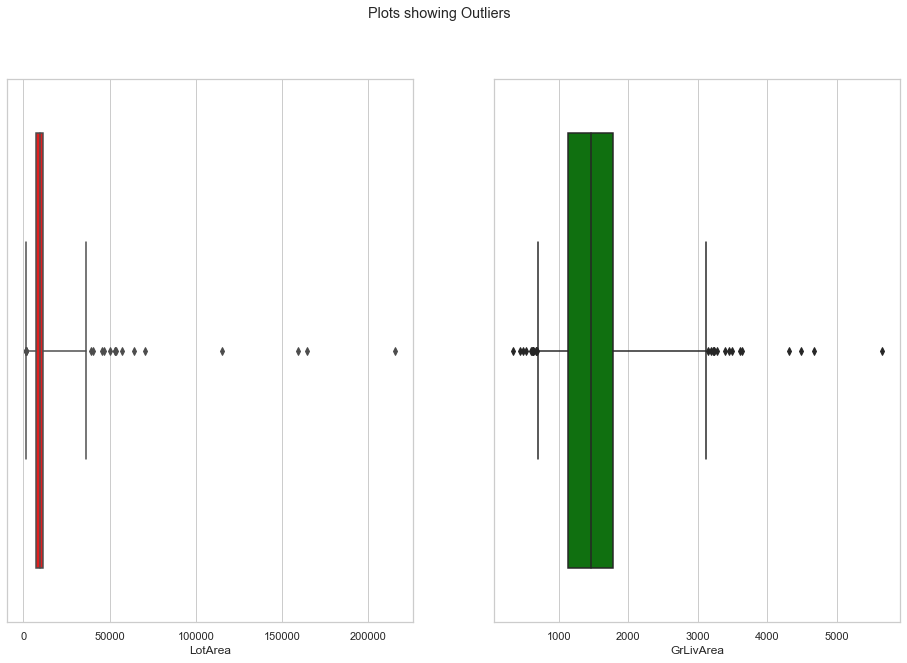

In [635]:
# Example of Outlier Visualization of two features
sns.set(style='whitegrid')
f,ax=plt.subplots(1,2,figsize=(16,10))
sns.boxplot(df.LotArea,ax=ax[0],color='red', whis=[1,99])
sns.boxplot(df.GrLivArea,ax=ax[1],color='green', whis=[1,99])
plt.suptitle('Plots showing Outliers')

In [636]:
# Tukey Method

n = 2 #In this case, we considered outliers as rows that have at least two outlied numerical values. The optimal value for this parameter can be later determined though the cross-validation
indexes = []

for col in df.columns[0:14]:
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col],75)
    IQR = Q3 - Q1

    limit = 1.5 * IQR

    list_outliers = df[(df[col] < Q1 - limit) | (df[col] > Q3 + limit )].index # Determine a list of indices of outliers for feature col

    indexes.extend(list_outliers) # append the found outlier indices for col to the list of outlier indices 

indexes = Counter(indexes)        
multiple_outliers = list( k for k, v in indexes.items() if v > n )

df.drop(multiple_outliers, axis = 0)

df = df.drop(multiple_outliers, axis = 0).reset_index(drop=True)
print(str(len(multiple_outliers)) + " outliers were eliminated")

42 outliers were eliminated


In [637]:
#You can try with this method to see if it provides better results
"""
#Setting the min/max to outliers using standard deviation
for col in df.columns[0:14]:
    factor = 3 #The optimal value for this parameter can be later determined though the cross-validation
    upper_lim = df[col].mean () + df[col].std () * factor
    lower_lim = df[col].mean () - df[col].std () * factor

    df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]
"""

'\n#Setting the min/max to outliers using standard deviation\nfor col in df.columns[0:14]:\n    factor = 3 #The optimal value for this parameter can be later determined though the cross-validation\n    upper_lim = df[col].mean () + df[col].std () * factor\n    lower_lim = df[col].mean () - df[col].std () * factor\n\n    df = df[(df[col] < upper_lim) & (df[col] > lower_lim)]\n'

## Transforming Skewed Continuous Features

In [638]:
def analyze_skew():
    #analyze which features are skewed
    fig = plt.figure(figsize = (35,20))
    cols = 3
    rows = math.ceil(float(df[numerical].shape[1] / cols))
    for i, column in enumerate(numerical):
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.set_title(column)
        if df.dtypes[column] == np.object:
            df[column].value_counts().plot(kind = 'bar', axes = ax)
        else:
            df[column].hist(axes = ax)
            plt.xticks(rotation = 'vertical')
    plt.subplots_adjust(hspace = 0.7, wspace = 0.2)
    plt.show()
    
    
    skew_feats = df[numerical].skew().sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew': skew_feats})
    
    display(skewness)
    return skewness

In [ ]:
skewness = analyze_skew()

In [639]:
#Let's reduce the skew of the features that have a skewness greater than 0.85
skew_feats = df[numerical].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewed = skewness.index[abs(skewness.iloc[:, 0]) > 0.85].tolist()
df[skewed] = df[skewed].astype(float)

In [ ]:
features_log_transformed = pd.DataFrame(data=df)
features_log_transformed[skewed] = df[skewed].apply(lambda x: np.log(x + 1)) #it can be other function like polynomial, but generally the log funtion is suitable

In [ ]:
#check again if is everything ok
analyze_skew()

# Feature Selection
- Feature Selection/Reduction (Remove useless features) -> See feature importance, correlations, Dimensionality reduction,

As we only have 14 features, we are not pressured to make a feature selection/reduction in order to increase drastically the computing time of the algorithms. So, for now, we are going to investigate if there are features extremely correlated to each other. After tuning and choosing the best model, we are revisiting feature selection methods just in case we face overfitting or to see if we could achieve the same results with the chosen model but with fewer features.

## Correlation

Since we have a mix of numerical and categorical variables, we are going to analyze the correlation between them independently and then mixed. 

- Numerical & Numerical: Pearson correlation is a good one to use, although there are others.
- Categorical & Categorical: We will make use Chi-squared and uncertainty correlation methods through a library called dython. 
- Numerical & Categorical: We can use point biserial correlation (only if categorical variable is binary type), or ANOVA test.

In [640]:
Y = df['SalePrice']
X = df.drop('SalePrice',axis=1)

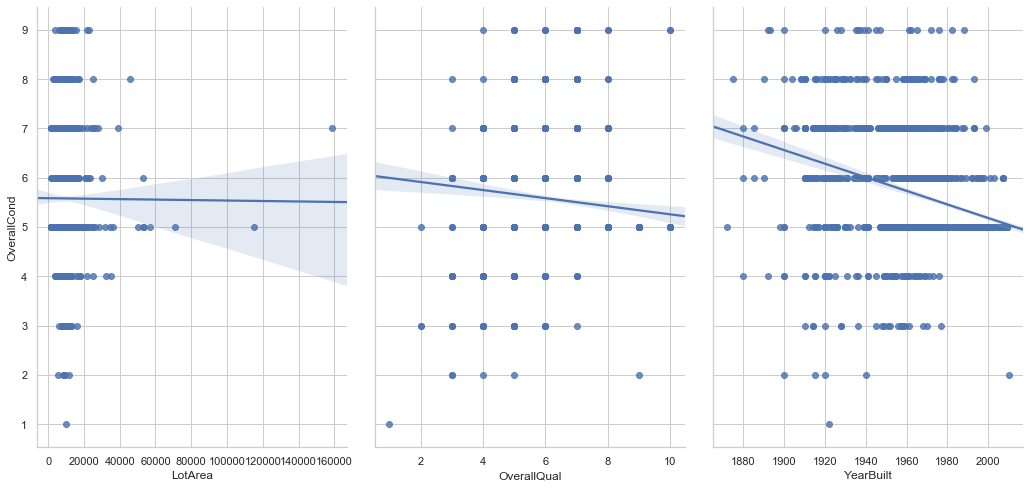

In [641]:
#Simple regression line of various variables in relation to  one other
sns.pairplot(X.astype(float), x_vars = ['LotArea', 'OverallQual', 'YearBuilt'], y_vars = 'OverallCond', size = 7, aspect = 0.7, kind = 'reg')

**Correlations between numerical features**

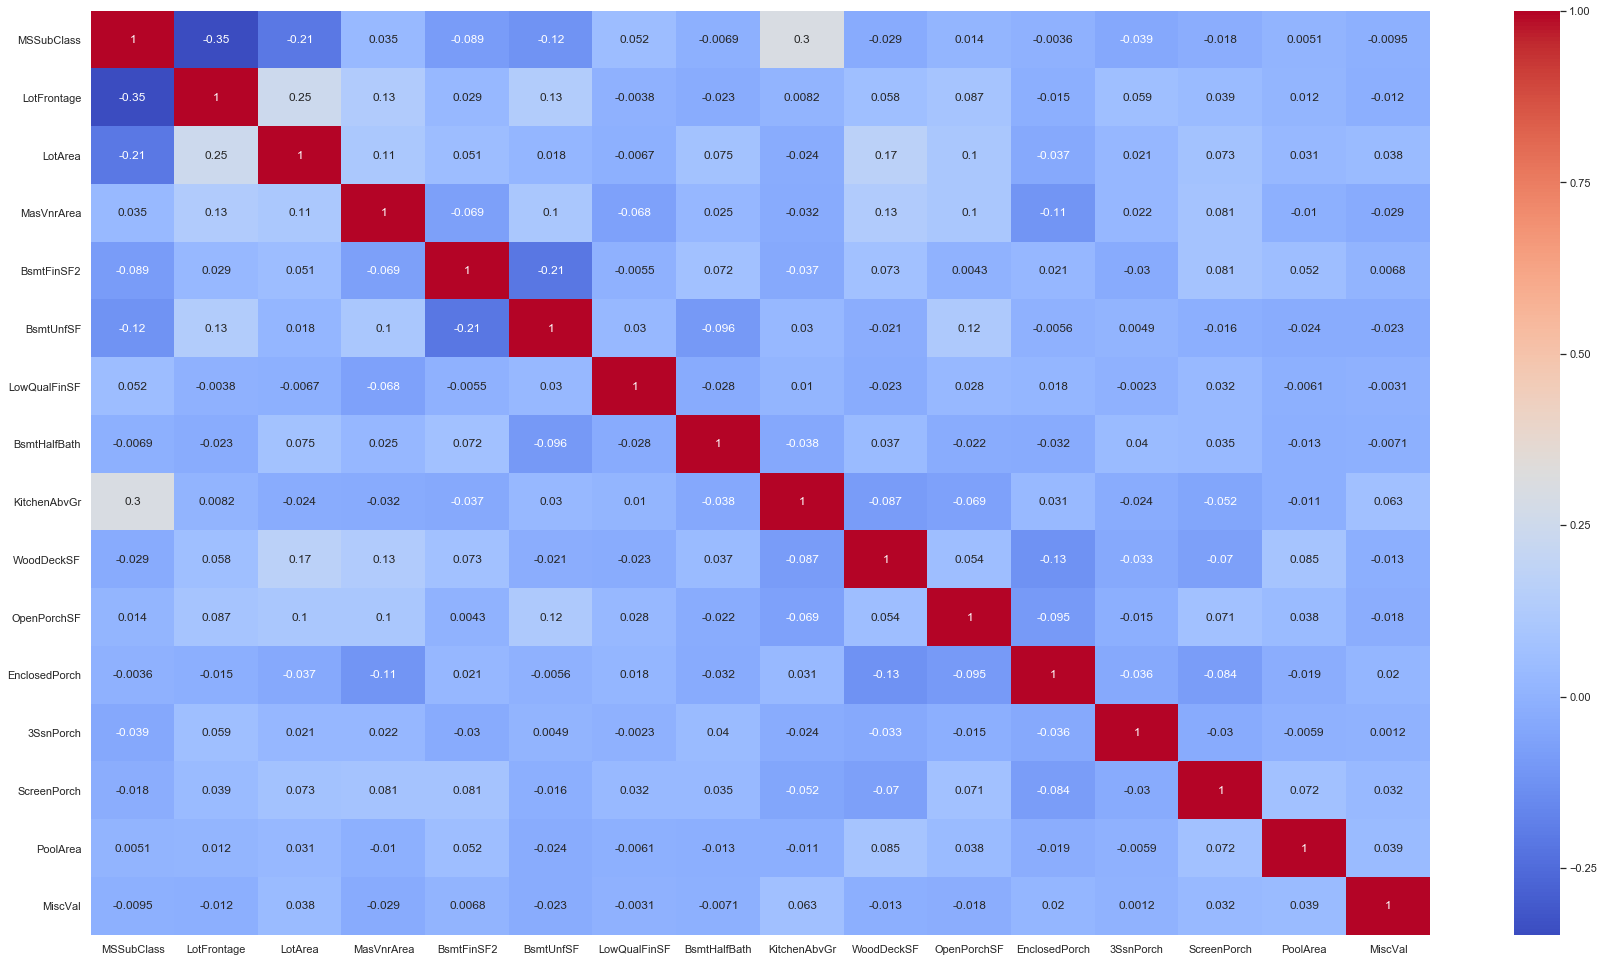

In [642]:
plt.subplots(figsize=(30,17))
sns.heatmap(X[numerical].corr(method = 'pearson'),annot=True,cmap='coolwarm') # the method can also be 'spearman' or kendall'

#to see the correlation between just two variables
#df['age'].corr(df['capital.gain']) 

**Correlations between categorical features**

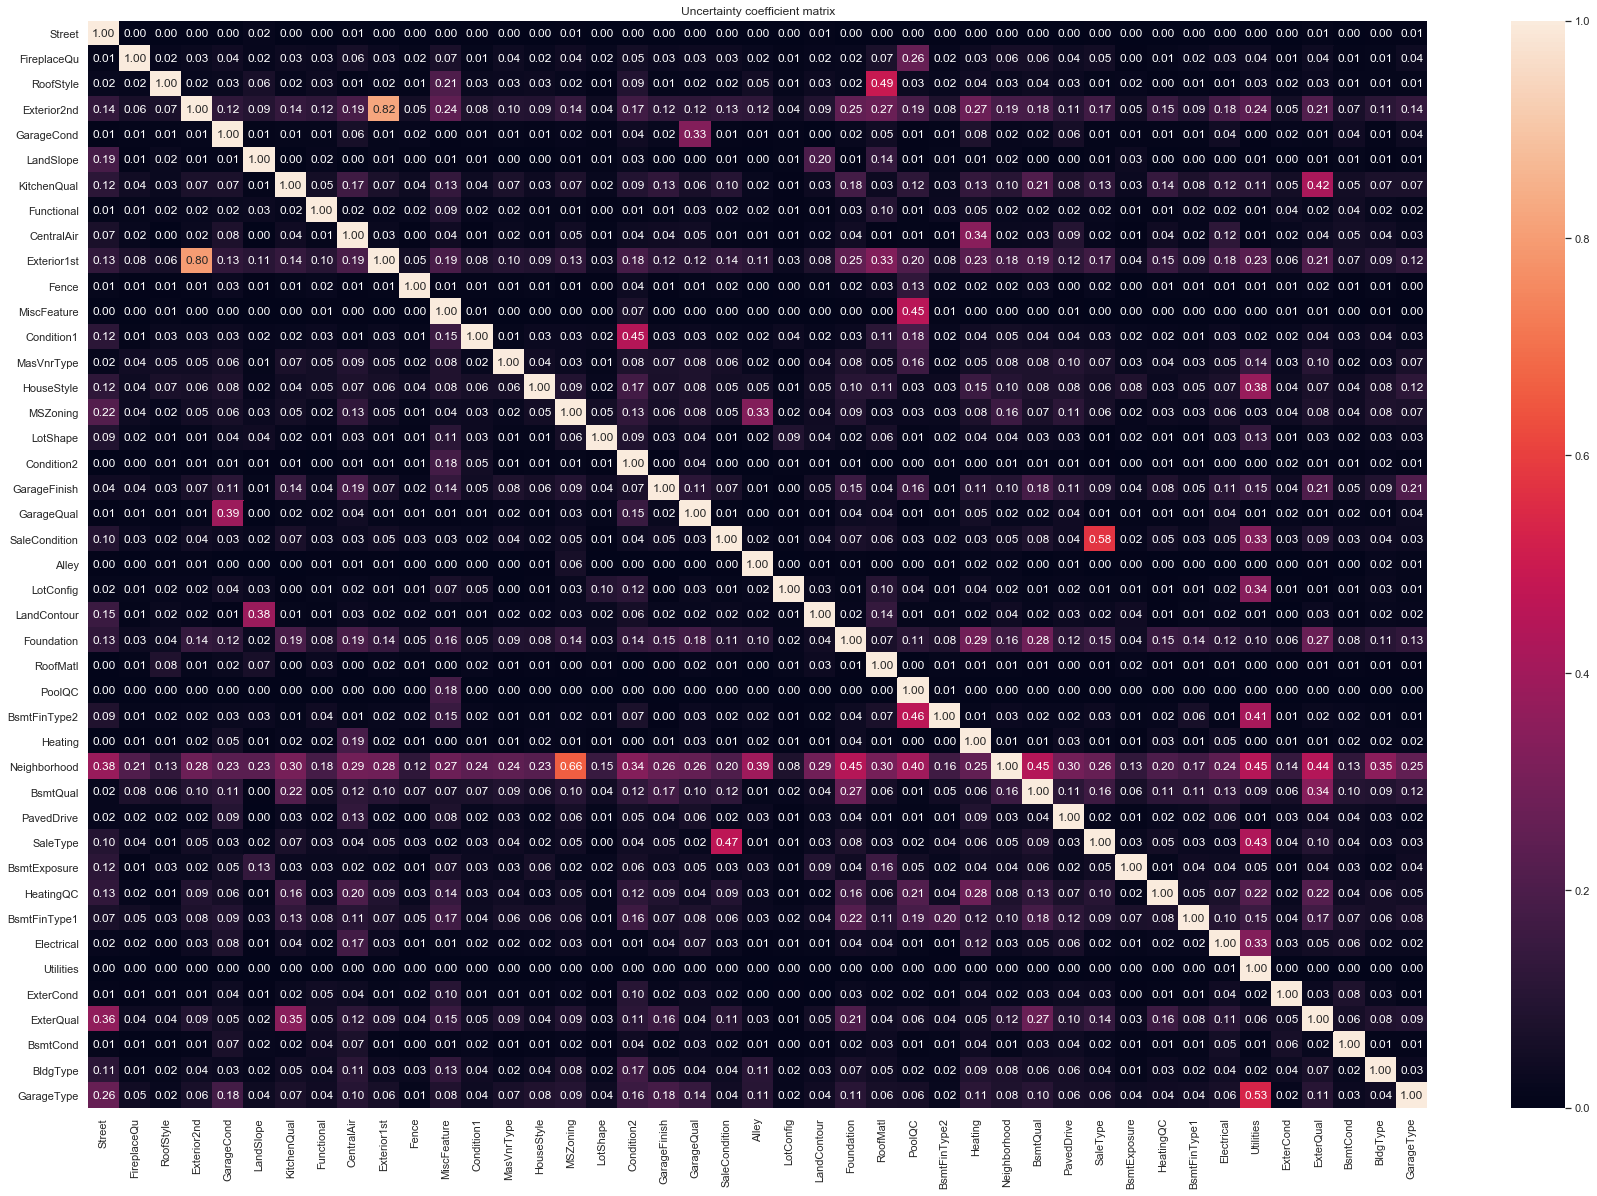

In [643]:
data = X[X.columns.intersection(categorical)]

cols = data.columns
clen = cols.size

pairings = list(itertools.product(data.columns, repeat=2))
theils_mat = np.reshape([nominal.theils_u(data[p[1]],data[p[0]]) for p in pairings],(clen,clen))
final = pd.DataFrame(theils_mat, index=cols, columns=cols)

fig, ax = plt.subplots(1,1, figsize=(30,20))
sns.heatmap(final,0,1,ax=ax,annot=True,fmt="0.2f").set_title("Uncertainty coefficient matrix")
plt.show()

**Correlations between categorical and numerical features**

In [644]:
for num_feature in numerical:
    for cat_feature in categorical:
        args_list = []
        for unique in X[cat_feature].unique():
            args_list.append(X[num_feature][X[cat_feature] == unique])
        
        f_val, p_val = st.f_oneway(*args_list) # Calculate f statistics and p value
        print("There are no statistical differences between the following pair of features:")
        
        if(p_val>0.05):
            print('Anova Result between ' + num_feature, ' & '+ cat_feature, ':' , f_val, p_val)  
        
        #TO-DO: reduce the features based on this

There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & Street : 0.1105528678915604 0.7395647939358603
There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & FireplaceQu : 0.9476471723884974 0.4354293042636793
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & GarageCond : 0.5814583370779959 0.6761184844546528
There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & LandSlope : 1.020107272162186 0.36082126335208287
There are no statistical differences between the following pair of features:
Anova Result between MSSubClass  & KitchenQual : 0.7634638265798047 0.5145647351296618
There are no statistical differenc

# Dimensionality Reduction

## T-SNE

In [645]:
train,test = train_test_split(df,test_size=0.3)

y_train = train['SalePrice']
X_train = train.drop('SalePrice',axis=1)
y_test = test['SalePrice']
X_test = test.drop('SalePrice',axis=1)

In [646]:
tsne = TSNE(n_components=2, random_state=42, verbose = 2)
TSNE_X = tsne.fit_transform(X_train)
TSNE_X_test = tsne.fit_transform(X_test)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 992 samples in 0.043s...
[t-SNE] Computed neighbors for 992 samples in 0.171s...
[t-SNE] Computed conditional probabilities for sample 992 / 992
[t-SNE] Mean sigma: 269.376711
[t-SNE] Computed conditional probabilities in 0.270s
[t-SNE] Iteration 50: error = 63.0869904, gradient norm = 0.2670290 (50 iterations in 1.737s)
[t-SNE] Iteration 100: error = 60.9720879, gradient norm = 0.2270847 (50 iterations in 0.969s)
[t-SNE] Iteration 150: error = 60.1577415, gradient norm = 0.2290918 (50 iterations in 0.916s)
[t-SNE] Iteration 200: error = 60.2192764, gradient norm = 0.2205848 (50 iterations in 0.956s)
[t-SNE] Iteration 250: error = 60.3623962, gradient norm = 0.2290929 (50 iterations in 0.829s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.362396
[t-SNE] Iteration 300: error = 0.7642614, gradient norm = 0.0009775 (50 iterations in 0.899s)
[t-SNE] Iteration 350: error = 0.6766788, gradient norm = 0.0003161

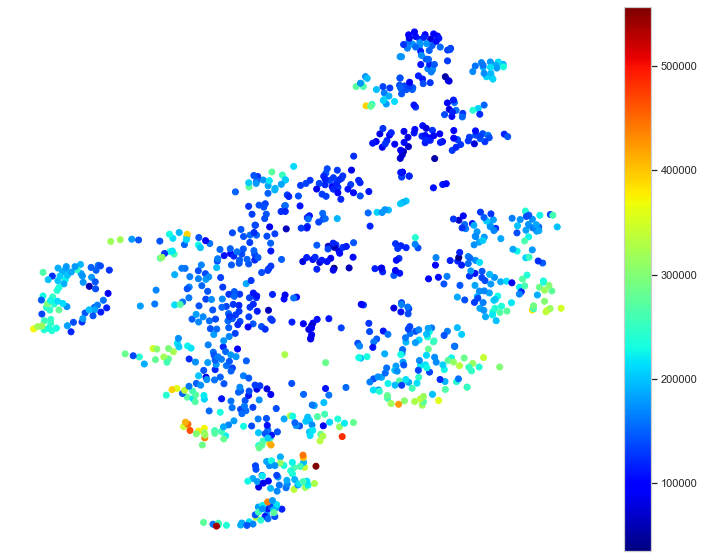

In [647]:
plt.figure(figsize=(13,10))
plt.scatter(TSNE_X[:, 0], TSNE_X[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

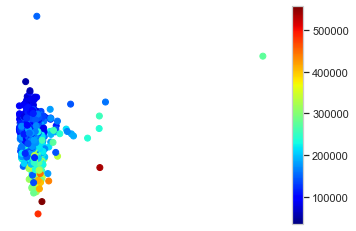

In [648]:
PCA_train_x = PCA(n_components=X_train.shape[1], random_state=42, svd_solver='full').fit_transform(X_train)
plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

## Kernel PCA

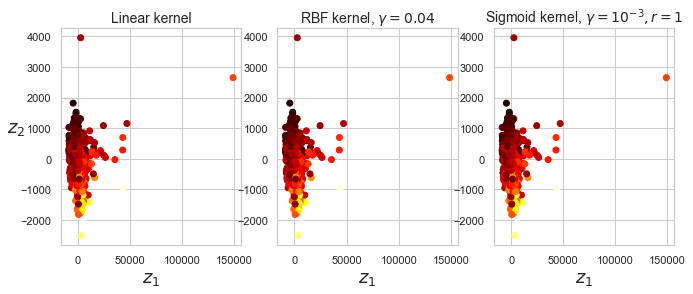

In [649]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
       
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Locally Linear Embedding

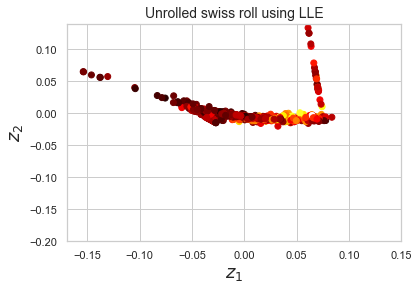

In [650]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
PCA_X = lle.fit_transform(X_train)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(PCA_X [:, 0], PCA_X [:, 1], c= y_train, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.170, 0.15, -0.200, 0.14])
plt.grid(True)
plt.show()

## PCA

In [651]:
#Scalling first a copy of the data
X_copy = X
col_names = X_copy.columns
features = X_copy[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X_copy[col_names] = features

n_comp = len(X_copy.columns)

pca = PCA(n_components=n_comp, svd_solver='full', random_state=1001)
X_pca = pca.fit_transform(X_copy)

print('Variance contributions of each feature:')
for j in range(n_comp):
    print(pca.explained_variance_ratio_[j])

Variance contributions of each feature:
0.1265628299434097
0.05310676560280522
0.04509756750136585
0.038386794099999795
0.029418060490109556
0.02691793186343873
0.02546092182433148
0.023370016858695202
0.022094231659405095
0.021094790139611193
0.02049417468797447
0.020191894604247394
0.019004929188849596
0.018225822355359498
0.017705171367265755
0.017110243980136376
0.0161508833066998
0.015396002894423505
0.015012097735486835
0.014577924980428524
0.014448563962210982
0.014002235396286178
0.01392961556089221
0.013798608611308941
0.013405510787998705
0.013054777984304426
0.012636094234299363
0.012291389476473399
0.012088587949140518
0.011651801725407829
0.011382688183029848
0.011130896208711997
0.010893152855149428
0.010652726860997044
0.010356584243811558
0.009954106675436517
0.009715838878034429
0.00963010016465693
0.00944764599732395
0.009228906369287781
0.009087324717417123
0.008688670553248276
0.00839140945357212
0.00799119765654197
0.007833884624484361
0.007720188968021387
0.007481

To-Do: execute the PCA because there are features with meaningful variance

## PCA + T-SNE

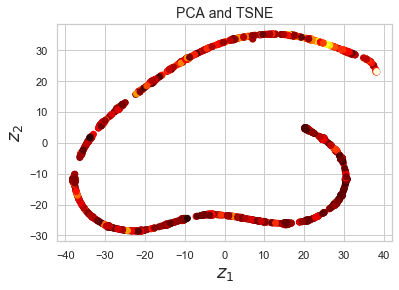

In [652]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42))
])
X_pca_tsne = pca_tsne.fit_transform(X_train)
plt.title("PCA and TSNE", fontsize=14)
plt.scatter(X_pca_tsne [:, 0], X_pca_tsne [:, 1], c= y_train, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.show()

It is difficult to separate the clusters.

In [653]:
#Saving data before OneHotEncoding to assess future importance later
X_not_encoded = copy.deepcopy(X)
X_not_encoded[X.columns] = StandardScaler().fit_transform(X) #not encoded yet, but scaled!

# Constructing the Pipeline | One Hot Encoding | Standardization

After analyzing the data and all the feature engineering possibilities, methods and what results from them, it is important to build an ML pipeline, i.e, a structure that encodes the sequence of all the transformations needed to each feature. 

This is particularly usefull for making predictions on new data. We want to transform new prediction data futurely to the standard with which our models were trained. 

We couldn't do at first because we had to know first if it would be needed to eliminate outliers or not, it would be needed to make reduce dimensionality, etc. Those operations can change the number of features left or created when we encode posteriorly.

So, our pipeline will only cover operations that can change the value and number of final features, and not other feature engineering aspects like class imbalance, skewness, outliers, etc.

- 1) We'll revert all the feature transformations absolutely needed to deal with class imbalance, skewness, outliers, pca, etc. For example: to check if a pca was needed, we had to standardize the values; to eliminate outliers, we had to encode the categorical variables before...So, in the end of this, we are able to fit the pipeline with all the data cleaned and with the original structure. 
      - Revert scaler -> binning -> label encoding
- 2) Construct and fit the pipeline with:
      - imputer (we want our model to be able to predict new data with missing fields) -> binning -> hot encoding -> scaler -> pca

We don't need to aggregate a preferred classifier right now to the pipeline because we will still assess and tune multiple models.

In [654]:
#inverse scaling X
X = pd.DataFrame(scaler.inverse_transform(X))
X.columns = df.columns[:-1]

#inverse label encoding X
for index, feature in enumerate(categorical):
    X[feature] = label_encoders[index].inverse_transform(X[feature].astype(int))


numeric_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=False)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=np.nan,  add_indicator=False)),
    ('onehot', OneHotEncoder(categories="auto", handle_unknown='ignore')),
    ('scaler', StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers = [
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])


temp = pipeline.fit_transform(X)
columns = numerical + pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical).tolist()

X = pd.DataFrame(temp.toarray(), columns=columns)


#Save the pipeline for later loading and make new predictions
joblib.dump(pipeline, './models/house_prices/preprocessing_pipeline.pkl')


['./models/house_prices/preprocessing_pipeline.pkl']

In [655]:
scaler_2 = StandardScaler().fit(Y.values.reshape(-1, 1))
Y = scaler_2.transform(Y.values.reshape(-1, 1))
Y = pd.DataFrame(Y, columns = ['SalePrice'])

In [656]:
# Here's code if we want to one hot encode just the categorical features without pipeline nd merge them with the numerical data for further standardization!
"""
encoder = OneHotEncoder(categories="auto")
encoded_feat = pd.DataFrame(encoder.fit_transform(df[categorical]).toarray(), columns=encoder.get_feature_names(categorical))

#concatenate without adding null values -.-''
l1=encoded_feat.values.tolist()
l2=df[numerical].values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])

X=pd.DataFrame(l1,columns=encoded_feat.columns.tolist()+df[numerical].columns.tolist())
"""

'\nencoder = OneHotEncoder(categories="auto")\nencoded_feat = pd.DataFrame(encoder.fit_transform(df[categorical]).toarray(), columns=encoder.get_feature_names(categorical))\n\n#concatenate without adding null values -.-\'\'\nl1=encoded_feat.values.tolist()\nl2=df[numerical].values.tolist()\nfor i in range(len(l1)):\n    l1[i].extend(l2[i])\n\nX=pd.DataFrame(l1,columns=encoded_feat.columns.tolist()+df[numerical].columns.tolist())\n'

In [657]:
# Here's code if we want to standardize without pipeline.
#Standard
"""
col_names = X.columns

features = X[col_names]

scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

X[col_names] = features
"""

'\ncol_names = X.columns\n\nfeatures = X[col_names]\n\nscaler = StandardScaler().fit(features.values)\nfeatures = scaler.transform(features.values)\n\nX[col_names] = features\n'

In [658]:
#We can also try the minimax and see if it results in better performances
"""
#Minimax
col_names = X.columns

features = X[col_names]

scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

X[col_names] = features
"""

'\n#Minimax\ncol_names = X.columns\n\nfeatures = X[col_names]\n\nscaler = MinMaxScaler().fit(features.values)\nfeatures = scaler.transform(features.values)\n\nX[col_names] = features\n'

# Colinearity After Encoding

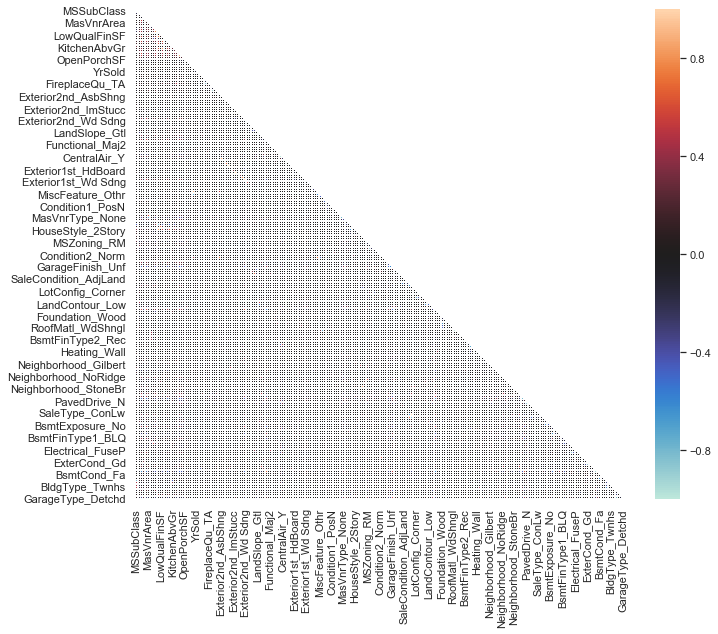

In [659]:
cols = X.columns
corr = X.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, vmax=1, center=0,vmin=-1 , 
            square=True, linewidths=.005)

After One Hot Encoding, it is expectable to have many colinear variables. This is a special concern for later use of methods like Linear Regression. So, for that it is essential to use the flag 'fit_intercept=False'. To-Do: Adopt other measures to fight multicolinearity.

# Split Data

### Shuffle before split

In [661]:
l1=X.values.tolist()
l2=pd.DataFrame(Y).values.tolist()
for i in range(len(l1)):
    l1[i].extend(l2[i])
    
new_df=pd.DataFrame(l1,columns=X.columns.tolist()+pd.DataFrame(Y).columns.tolist())

new_df = shuffle(new_df, random_state=42)

In [662]:
testSize = 0.3 #we can try with different test_sizes

#dividing features that were not hotencoded for frther analysis of the feature importance for each classifier
X_original_train, X_original_test, y_original_train, y_original_test = train_test_split(X_not_encoded, Y, test_size = 0.2) 

train,test = train_test_split(new_df,test_size=testSize)

y_train = train['SalePrice']
X_train = train.drop('SalePrice',axis=1)
y_test = test['SalePrice']
X_test = test.drop('SalePrice',axis=1)

# Building Classifiers and Finding their Best Parameters
Just tuning the critial parameters, not all of them.
I intercalate between randomizedSearch and GridSearch to diversify and adjust accordingly to the number of parameters needed to test.

In [663]:
models = []
tree_classifiers = [] #useful to analyze SHAP values later
tuning_num_folds = 3
jobs=4
num_random_state=10
scoring_criteria='neg_mean_squared_error'
predictions = pd.DataFrame()

In [664]:
def permutation_importance(fittted_model, XTest, YTest):

    perm_model = PermutationImportance(fittted_model, random_state = num_random_state, cv = 'prefit', scoring="neg_mean_squared_error")
    perm_model.fit(XTest, YTest, scoring="neg_mean_squared_error")
    
    display(show_weights(perm_model, feature_names = list(XTest.columns)))

In [701]:
def check_fitting(model, name):
    
    plt.figure(figsize = (12,8))

    number_chunks = 20
    train_sizes, train_scores, test_scores = learning_curve(model, X, Y, 
                                            train_sizes = np.linspace(0.01, 1.0, number_chunks), cv = 10, scoring = 'neg_mean_squared_error', 
                                            n_jobs = -1, random_state = 0)
    
    
    train_scores = pd.DataFrame(train_scores).multiply(-1).to_numpy()
    test_scores = pd.DataFrame(test_scores).multiply(-1).to_numpy()
    
    train_mean = np.mean(train_scores, axis = 1)
    train_std = np.std(train_scores, axis = 1)

    test_mean = np.mean(test_scores, axis = 1)
    test_std = np.std(test_scores, axis = 1)  

    plt.plot(train_sizes, train_mean, '*-', color = 'blue',  label = 'Training score')
    plt.plot(train_sizes, test_mean, '*-', color = 'yellow', label = 'Cross-validation score')
    
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.1, color = 'b') # Alpha controls band transparency.
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.1, color = 'y')
    
    font_size = 12
    plt.xlabel('Training Set Size', fontsize = font_size)
    plt.ylabel('MSE Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')
    plt.grid()
    
    plt.suptitle('Check for Overfitting/Underfitting Issues of ' + name + ' When Submited to Different Training Sizes', fontsize = 15)
    plt.tight_layout(rect = [0, 0.03, 1, 0.97])
    Path("./results/house_prices/" + name).mkdir(parents=True, exist_ok=True)
    plt.grid()
    #saving the image
    plt.savefig('./results/house_prices/' + name + '/learning_curve.png')
    plt.show()

In [666]:
# It displays the scores of the combinations of the tunning parameters. It is useful, for example, to see if a parameter is really worth to wasting time to varying it by assess the impact that its variation has in the score
# It can only be applied when we use grid search because we know the combinations made,contrary to randomSearch
def display_tuning_scores(params, tunning):
    
    keys  = list(params.keys())
    lengths = [len(params[x]) for x in keys]
    if 1 in lengths:
        lengths.remove(1)
    lengths.sort(reverse=True)
    master_scores = tunning.cv_results_['mean_test_score']
    
    for length in lengths:
        for key, value in params.items():
            if len(value) == length:
                myKey = key
                break

        scores = np.array(master_scores).reshape(tuple(lengths))
        scores = [x.mean() for x in scores]
        scores = pd.Series(scores).mul(-1).tolist() # multiplied per -1 because we want to know the true mse
        
        plt.figure(figsize=(10,5))
        plt.plot(params[myKey],scores, '*-',)
        plt.xlabel(myKey)
        plt.ylabel('Mean score')
        plt.show()
        params.pop(myKey, None)
        lengths = lengths[1:] + [lengths[0]]

## Random Forest Regressor Tuning

In [667]:
name = 'Random Forest'
params = {'n_estimators' : [70,100], 'min_samples_split' : [3,4,6,10], 'random_state': [5] }


skf = KFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(RandomForestRegressor(), param_distributions=params, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

#These two lines are useful to analyze SHAP values later
tree_classifiers.append(('Random Forest', RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'], min_samples_split=random_search.best_params_['min_samples_split'])))
tree_classifiers.append(('Random Forest', RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'], min_samples_split=random_search.best_params_['min_samples_split'])))

model_config_1 = RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'], min_samples_split=random_search.best_params_['min_samples_split'])
model_config_2 = RandomForestRegressor(n_estimators=random_search.best_params_['n_estimators'], min_samples_split=random_search.best_params_['min_samples_split'])
tunned_model = model_config_1.fit(X_train,y_train)
models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))    

Fitting 2 folds for each of 8 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed:   33.2s finished


## Tuning Linear Regression

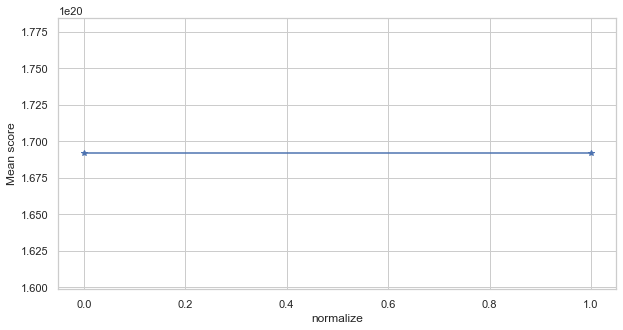

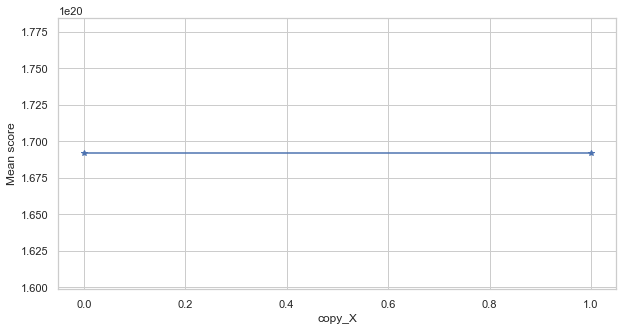

In [668]:
name = 'Linear Regression'

param = {'fit_intercept':[False], 'normalize':[True,False], 'copy_X':[True, False]}

grid = GridSearchCV(LinearRegression(), param,verbose=False, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = LinearRegression(fit_intercept=grid.best_params_['fit_intercept'], normalize=grid.best_params_['normalize'], copy_X=grid.best_params_['copy_X'])
model_config_2 = LinearRegression(fit_intercept=grid.best_params_['fit_intercept'], normalize=grid.best_params_['normalize'], copy_X=grid.best_params_['copy_X'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))    

## Ridge tuning

Fitting 2 folds for each of 48 candidates, totalling 96 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.7s
[Parallel(n_jobs=4)]: Done  96 out of  96 | elapsed:    2.1s finished


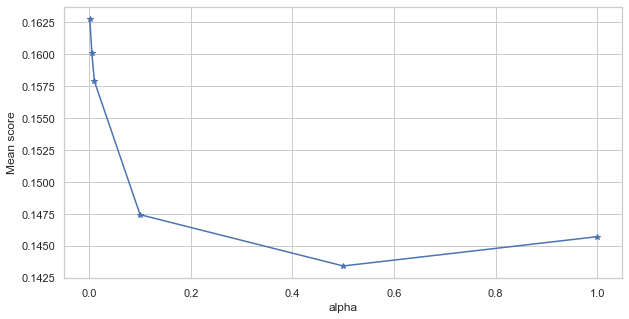

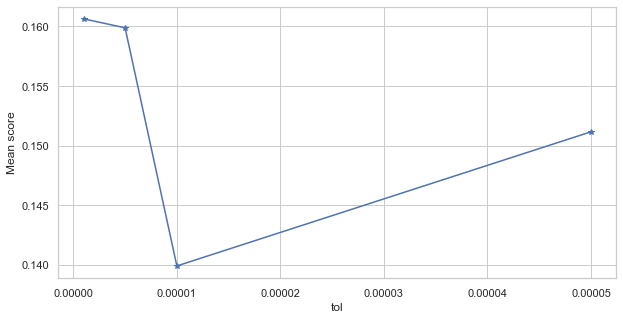

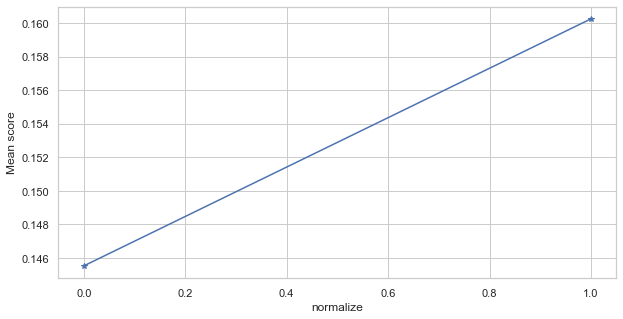

In [669]:
name = 'Ridge'

param = {'alpha':[0.001,0.005,0.01,0.1,0.5,1], 'normalize':[True,False], 'tol':[1e-06,5e-06,1e-05,5e-05]}


grid = GridSearchCV(Ridge(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = Ridge(alpha=grid.best_params_['alpha'], normalize=grid.best_params_['normalize'], tol=grid.best_params_['tol'])
model_config_2 = Ridge(alpha=grid.best_params_['alpha'], normalize=grid.best_params_['normalize'], tol=grid.best_params_['tol'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))    

## Lasso tuning

In [670]:
name = 'Lasso'
params = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}


skf = KFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(Lasso(), param_distributions=params, scoring=scoring_criteria, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = Lasso(alpha=random_search.best_params_['alpha'], normalize=random_search.best_params_['normalize'], tol=random_search.best_params_['tol'])
model_config_2 = Lasso(alpha=random_search.best_params_['alpha'], normalize=random_search.best_params_['normalize'], tol=random_search.best_params_['tol'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))      

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  13 out of  20 | elapsed:    0.8s remaining:    0.4s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    1.4s finished


## Elastic Net tuning

Fitting 2 folds for each of 36 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:    1.2s finished


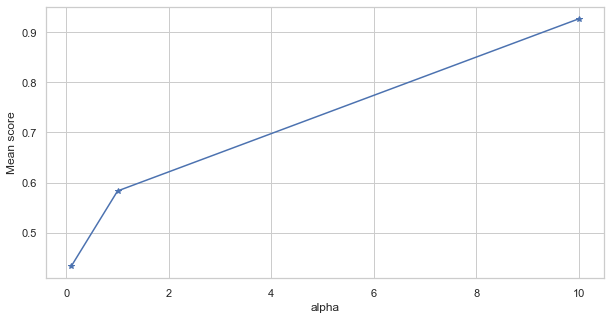

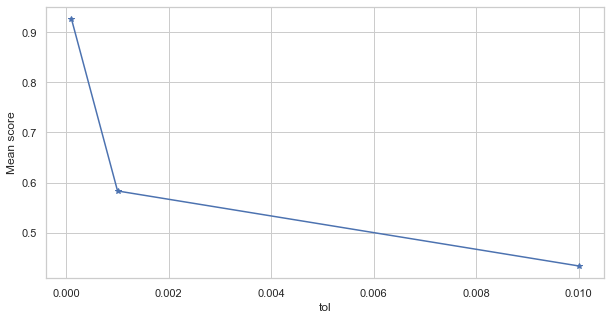

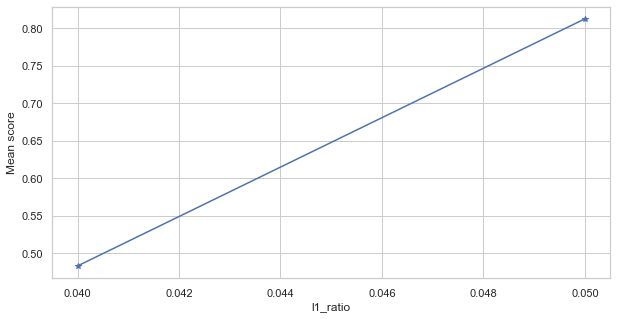

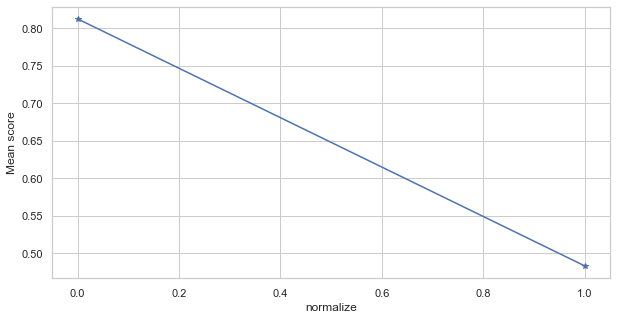

In [671]:
name = 'Elastic Net'

param={'alpha' :[0.1,1.0,10], 'l1_ratio':[0.04,0.05],'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}

grid = GridSearchCV(ElasticNet(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = ElasticNet(alpha=grid.best_params_['alpha'], l1_ratio=grid.best_params_['l1_ratio'], normalize=grid.best_params_['normalize'], tol=grid.best_params_['tol'])
model_config_2 = ElasticNet(alpha=grid.best_params_['alpha'], l1_ratio=grid.best_params_['l1_ratio'], normalize=grid.best_params_['normalize'], tol=grid.best_params_['tol'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))     

## DecisionTreeClassifier tuning

Since each split in the decision tree distinguishes the dependent variable, splits closer to the root, aka starting point, have optimally been determined to have the greatest splitting effect. The feature importance graphic measures how much splitting impact each feature has. It is important to note that this by no means points to causality, but just like in hierarchical clustering, does point to a nebulous groups. Furthermore, for ensemble tree methods, feature impact is aggregated over all the trees.

In [672]:
name = 'DT'
param = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14], 'max_leaf_nodes' : [None, 12,15,18,20] }

grid = GridSearchCV(DecisionTreeRegressor(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

Fitting 2 folds for each of 80 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 153 out of 160 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed:    2.0s finished


GridSearchCV(cv=KFold(n_splits=2, random_state=10, shuffle=True),
             error_score=nan,
             estimator=DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse',
                                             max_depth=None, max_features=None,
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='deprecated',
                                             random_state=None,
                                             splitter='best'),
             iid='deprecated', n_jobs=4,
             param_grid={'max_depth': [7, 8, 9, 10],
                         'max_features': [11,

In [673]:
"""
# Helper Function to visualize feature importance if needed
plt.rcParams['figure.figsize'] = (8, 4)
predictors = [x for x in X.columns]
def feature_imp(model):
    MO = model.fit(X_train, y_train)
    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
"""


"\n# Helper Function to visualize feature importance if needed\nplt.rcParams['figure.figsize'] = (8, 4)\npredictors = [x for x in X.columns]\ndef feature_imp(model):\n    MO = model.fit(X_train, y_train)\n    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)\n    feat_imp.plot(kind='bar', title='Feature Importances')\n    plt.ylabel('Feature Importance Score')\n"

**Pruning the decision trees**

Adapted from [here](https://stackoverflow.com/questions/49428469/pruning-decision-trees)

In [674]:
"""traverse the tree and remove all children of the nodes with minimum class count less than 5  (or any other condition you can think of)."""
def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)



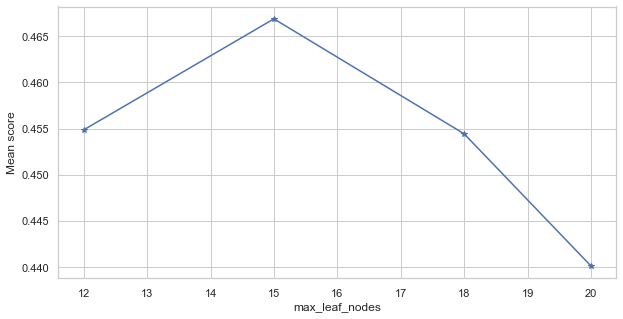

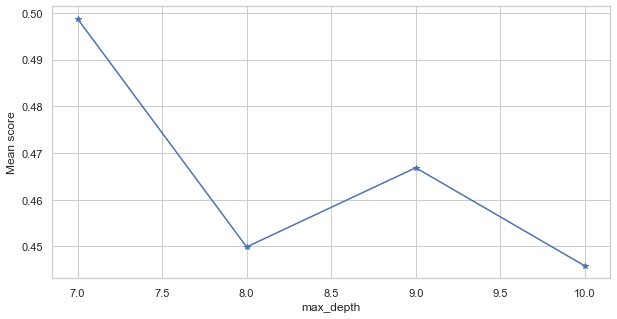

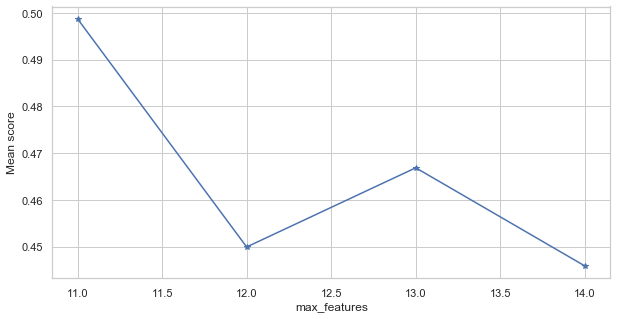

In [675]:
#These two lines are useful to analyze SHAP values later
tree_classifiers.append(('DT', DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], max_leaf_nodes=grid.best_params_['max_leaf_nodes'])))
tree_classifiers.append(('DT', DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], max_leaf_nodes=grid.best_params_['max_leaf_nodes'])))

model_config_1 = DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], max_leaf_nodes=grid.best_params_['max_leaf_nodes'])
model_config_2 = DecisionTreeRegressor(max_depth=grid.best_params_['max_depth'], max_features=grid.best_params_['max_features'], max_leaf_nodes=grid.best_params_['max_leaf_nodes'])
tunned_model = model_config_1.fit(X_train,y_train)

prune_index(tunned_model.tree_, 0, 5)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))    

## SVR tuning

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:  1.9min finished


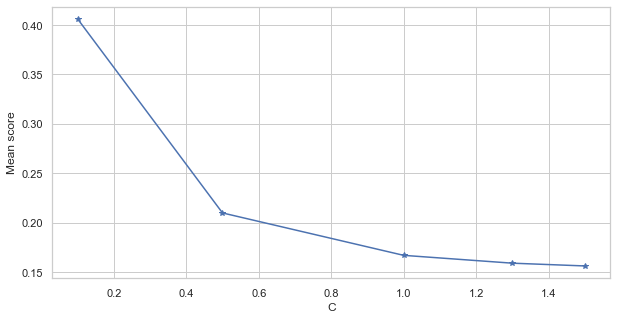

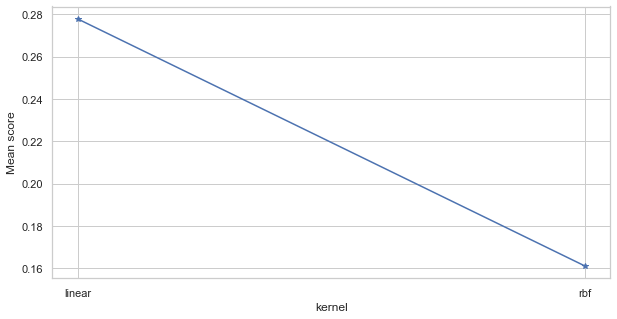

In [676]:
name = 'SVR'
param={'C':[0.1,0.5, 1,1.3,1.5],
      'kernel': ["linear","rbf"]
      }

grid = GridSearchCV(SVR(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = SVR(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
model_config_2 = SVR(C=grid.best_params_['C'], kernel=grid.best_params_['kernel'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

### KNN Regressor tuning

In [677]:
name = 'KNN'
params ={'n_neighbors' : [3,5,10],  
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['brute']}

random_search = RandomizedSearchCV(KNeighborsRegressor(), param_distributions=params, scoring=scoring_criteria, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = KNeighborsRegressor(n_neighbors=random_search.best_params_['n_neighbors'], weights=random_search.best_params_['weights'], algorithm=random_search.best_params_['algorithm'])
model_config_2 = KNeighborsRegressor(n_neighbors=random_search.best_params_['n_neighbors'], weights=random_search.best_params_['weights'], algorithm=random_search.best_params_['algorithm'])
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 2 candidates, totalling 4 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished


### Gaussian Process Tuning

In [678]:
name = 'Gaussian'
param = {'normalize_y' : [True,False],
              'kernel' : [DotProduct(), ConstantKernel(1.0, (1e-3, 1e3))] }

grid = GridSearchCV(GaussianProcessRegressor(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = GaussianProcessRegressor(normalize_y=grid.best_params_['normalize_y'], kernel=grid.best_params_['kernel'])
model_config_2 = GaussianProcessRegressor(normalize_y=grid.best_params_['normalize_y'], kernel=grid.best_params_['kernel'])

tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed:    4.8s finished


## Boosting

### GradientBoostingClassifier tuning

In [679]:
name = 'GraBoost'
param_grid ={
            'n_estimators': [5,10,15,20,25],
            'max_depth': [5,7,10],
            'learning_rate' : [0.01,0.1,1,10]
            }

random_search = RandomizedSearchCV(GradientBoostingRegressor(), param_distributions=param_grid, scoring=scoring_criteria, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = GradientBoostingRegressor(n_estimators=random_search.best_params_['n_estimators'], max_depth=random_search.best_params_['max_depth'], learning_rate=random_search.best_params_['learning_rate'], verbose=0)
model_config_2 = GradientBoostingRegressor(n_estimators=random_search.best_params_['n_estimators'], max_depth=random_search.best_params_['max_depth'], learning_rate=random_search.best_params_['learning_rate'], verbose=0)
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.8s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.8s finished


### XGB Regressor Tuning

In [680]:
name = 'XGB'
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],'max_depth': [2,3,4]}


skf = KFold(n_splits=tuning_num_folds, shuffle = True)

random_search = RandomizedSearchCV(XGBRegressor(), param_distributions=params, scoring=scoring_criteria, n_jobs=jobs, cv=skf.split(X_train,y_train), verbose=3, random_state=num_random_state)
random_search.fit(X_train,y_train)

model_config_1 = XGBRegressor(min_child_weight=random_search.best_params_['min_child_weight'],gamma=random_search.best_params_['gamma'], max_depth=random_search.best_params_['max_depth'], verbose=0)
model_config_2 = XGBRegressor(min_child_weight=random_search.best_params_['min_child_weight'],gamma=random_search.best_params_['gamma'], max_depth=random_search.best_params_['max_depth'], verbose=0)
tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

print(name + " - Learning Curve")
check_fitting(model_config_2, name)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   22.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   22.3s finished


### Catboost Process Tuning

Fitting 2 folds for each of 45 candidates, totalling 90 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  90 out of  90 | elapsed:  3.1min finished


0:	learn: 0.9413067	total: 9.07ms	remaining: 1.8s
1:	learn: 0.8871075	total: 16.4ms	remaining: 1.62s
2:	learn: 0.8336392	total: 25.6ms	remaining: 1.68s
3:	learn: 0.7833815	total: 34.2ms	remaining: 1.68s
4:	learn: 0.7455445	total: 40.6ms	remaining: 1.58s
5:	learn: 0.7074423	total: 56.1ms	remaining: 1.81s
6:	learn: 0.6776531	total: 67.9ms	remaining: 1.87s
7:	learn: 0.6462446	total: 76.1ms	remaining: 1.82s
8:	learn: 0.6207105	total: 97.1ms	remaining: 2.06s
9:	learn: 0.5940192	total: 103ms	remaining: 1.95s
10:	learn: 0.5699967	total: 113ms	remaining: 1.94s
11:	learn: 0.5466706	total: 121ms	remaining: 1.9s
12:	learn: 0.5266030	total: 140ms	remaining: 2.01s
13:	learn: 0.5065891	total: 148ms	remaining: 1.96s
14:	learn: 0.4885819	total: 157ms	remaining: 1.94s
15:	learn: 0.4772132	total: 187ms	remaining: 2.15s
16:	learn: 0.4647114	total: 194ms	remaining: 2.09s
17:	learn: 0.4511997	total: 223ms	remaining: 2.26s
18:	learn: 0.4376484	total: 241ms	remaining: 2.3s
19:	learn: 0.4267086	total: 258ms	r

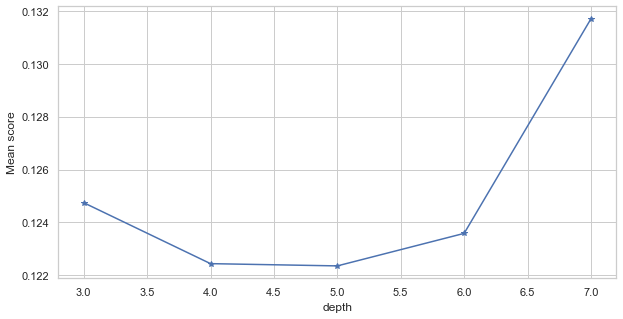

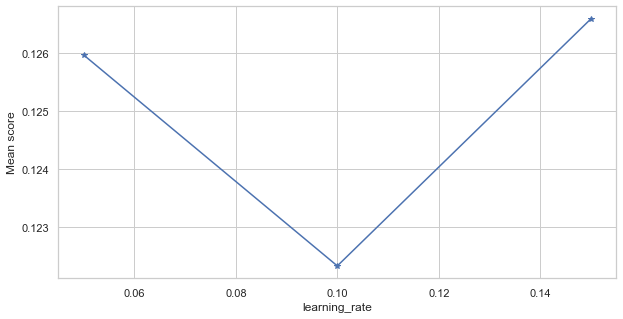

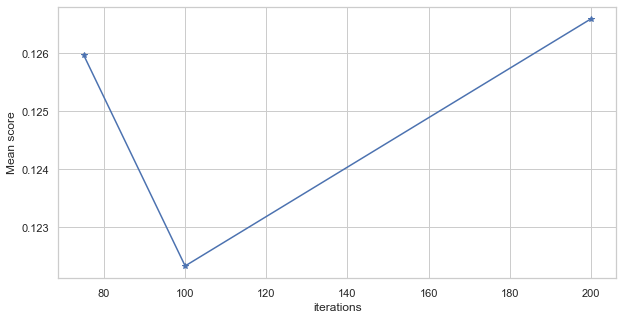

In [681]:
name = 'CAT'
param = {'depth': [3,4,5,6,7],
                'learning_rate': [0.05,0.1,0.15],
                'iterations': [75,100,200]}
grid = GridSearchCV(CatBoostRegressor(), param,verbose=True, cv = KFold(n_splits=tuning_num_folds,random_state=num_random_state,shuffle=True), n_jobs=jobs,scoring=scoring_criteria)
grid.fit(X_train,y_train)

model_config_1 = CatBoostRegressor(depth=grid.best_params_['depth'], learning_rate=grid.best_params_['learning_rate'], iterations=grid.best_params_['iterations'])
model_config_2 = CatBoostRegressor(depth=grid.best_params_['depth'], learning_rate=grid.best_params_['learning_rate'], iterations=grid.best_params_['iterations'])

tunned_model = model_config_1.fit(X_train,y_train)

models.append((name, tunned_model))

#let's save the predictions to analyze later their correlation
predictions[name] = tunned_model.predict(X_test)

print(name + " - Learning Curve")
check_fitting(model_config_2, name)

#Analyze feature importance of Original Data
print(name + " - Feature Importances")
permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)

#display tunning parameters scores
display_tuning_scores(param, grid)

#saving model
pickle.dump(tunned_model, open('./models/house_prices/' + name + '_model.sav', 'wb'))  

## Ensemble Methods

**Studying Correlation**
If base models' predictions are weakly correlated with each other, the ensemble will likely to perform better. On the other hand, for a strong correlation of predictions among the base models, the ensemble will unlikely to perform better. 

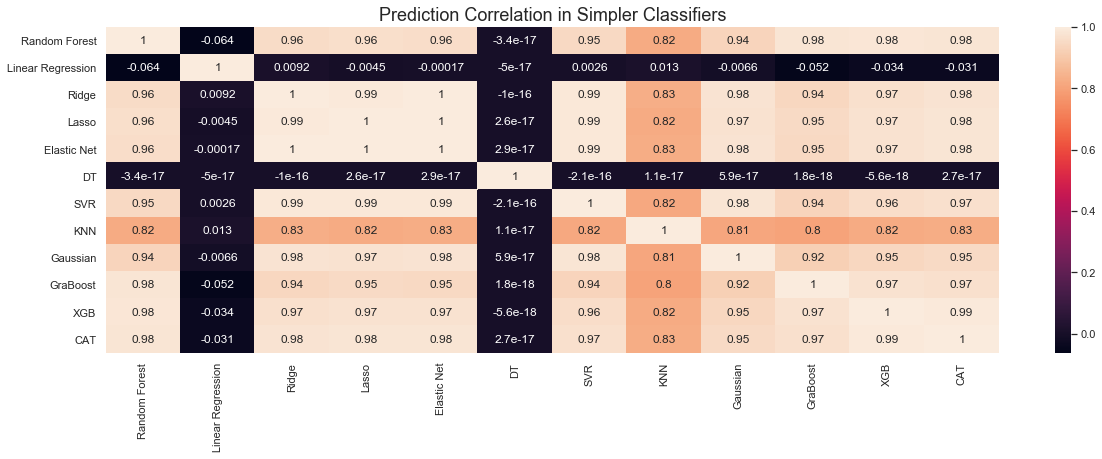

In [682]:
plt.figure(figsize = (20, 6))
correlations = predictions.corr()
sns.heatmap(correlations, annot = True)
plt.title('Prediction Correlation in Simpler Classifiers', fontsize = 18)
plt.show()

**As we can see, there are some classifiers that have a high correlated predictions. So, we won't use them to form the ensemble models.**

In [683]:
classifiers = copy.deepcopy(models)
every_model = copy.deepcopy(models)

for i in range(0, len(correlations.columns)):
    for j in range(0, len(correlations.columns)):
        if j>=i:
            break
        else:
            if abs(correlations.iloc[i,j]) >= 0.85:
                for index, clf in enumerate(classifiers):
                    if correlations.columns[j] == clf[0]:
                        del classifiers[index]
                
classifiers = [i[1] for i in classifiers]

### Voting

In [684]:
def voting(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    copy_1 = average_results[average_results.Model.isin([i[0] for i in models])]
    copy_1.sort_values(by=["Test Accuracy"], ascending=True, inplace=True)

    numb_voters = np.arange(2,len(classifiers)+1,1)

    #we we'll try to ensemble the best two classifiers, then the best three, the best, four, etc
    for i in numb_voters:
        models_names = list(copy_1.iloc[0:i,0])
        voting_models = []
        for model1 in models_names:
            for model2 in models:
                if model2[0] == model1:
                    voting_models.append(model2)

        model_config_1 = VotingRegressor(voting_models) 
        model_config_2 = VotingRegressor(voting_models) 
        model = model_config_1.fit(X_train,Y_train)

        name = "Voter_" + str(i) + "_best"

        #Analyze feature importance of Original Data
        print(name + " - Feature Importances")
        permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)
        
        every_model.append((name, model))
        pickle.dump(model, open('./models/house_prices/' + name + '_model.sav', 'wb'))
        average_results,models_test_mses, models_train_mses, models_validation_mses = classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)

    return average_results,models_test_mses, models_train_mses, models_validation_mses

### Bagging (Bootstrapping Aggregation)

Bagging is characteristic of random forest. You bootstrap or subdivide the same training set into multiple subsets or bags. This steps is also called row sampling with replacement. Each of these training bags will feed a mmodel to be trained. After each model being trained, it is time for aggragation, in other orders, to predict the outcome based on a voting system of each model trained.

In [685]:
def bagging(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):

    random_forest_regressor = RandomForestRegressor() # is the random forest classifier

    model_config_1 = BaggingRegressor(base_estimator = random_forest_regressor, verbose = 0, n_jobs = -1, random_state = seed)
    model_config_2 = BaggingRegressor(base_estimator = random_forest_regressor, verbose = 0, n_jobs = -1, random_state = seed)
    
    model = model_config_1.fit(X_train, Y_train)
    name = "bagging"
    
    #Analyze feature importance of Original Data
    print(name + " - Feature Importances")
    permutation_importance(model_config_2.fit(X_original_train,y_original_train), X_original_test, y_original_test)
    
    every_model.append((name, model))
    pickle.dump(model, open('./models/house_prices/' + name + '_model.sav', 'wb'))
    
    return classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)
    
    

### Blending

In [686]:
def blending(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    
    copy_2 = average_results[average_results.Model.isin([i[0] for i in models])]
    copy_2.sort_values(by=["Test Accuracy"], ascending=True, inplace=True)

    numb_voters = np.arange(2,len(classifiers)+1,1)

    #we we'll try to ensemble the best two classifiers, then the best three, the best, four, etc
    for i in numb_voters:
        models_names = list(copy_2.iloc[0:i,0])
        blending_models = []
        for model1 in models_names:
            for model2 in models:
                if model2[0] == model1:
                    blending_models.append(model2[1])

        blend_1 = BlendEnsemble(n_jobs = -1, test_size = 0.5, random_state = seed, scorer="accuracy")
        blend_1.add(blending_models) 
        blend_1.add_meta(RandomForestRegressor())

        blend_2 = BlendEnsemble(n_jobs = -1, test_size = 0.5, random_state = seed)
        blend_2.add(blending_models) #proba=true s important in order to predict_proba function properly later
        blend_2.add_meta(RandomForestRegressor())

        model = blend_1.fit(X_train, Y_train, scoring=scoring_criteria)
        name = "blending_" + str(i) + "_best"

        #Analyze feature importance of Original Data
        print(name + " - Feature Importances")
        permutation_importance(blend_2.fit(X_original_train,y_original_train, scoring="accuracy"), X_original_test, y_original_test)
        
        every_model.append((name, model))
        pickle.dump(model, open('./models/house_prices/' + name + '_model.sav', 'wb'))

        average_results,models_test_mses, models_train_mses, models_validation_mses = classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)

        
    return average_results,models_test_mses, models_train_mses, models_validation_mses


### Stacking

Shortly, we are trying to fit a model upon Y_valid data and models' predictions (stacked) made during the validation stage. Then, we will try to predict from the models' predictions (stacked) of test data to see if we reach Y_test values.

In this model we can't analyze the true feature importance because all the features that matter are the predictions of the classifiers!

In [687]:
def stacking_function(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring):
    numb_voters = np.arange(2,len(classifiers)+1, 1)

    S_train, S_test = stacking(classifiers, X_train, Y_train, X_test, regression = True, mode = 'oof_pred_bag', needs_proba = False, save_dir = None,metric = accuracy_score, n_folds = num_folds, shuffle = True, random_state =  seed, verbose = 0)                

    super_learner = RandomForestRegressor()
    model_1 = super_learner.fit(S_train, Y_train)
    name = "stacking"
    
    every_model.append((name, model_1))
    pickle.dump(model_1, open('./models/house_prices/' + name + '_model.sav', 'wb'))
    
    return classify_performance(name, model_1, S_train, S_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)


# Runs
**First of all, we'll execute 30 tests of cross-validation of all the models but with different seeds.**

In [688]:
def classify_performance(name, model, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses):

    cv_results = cross_validate(model, X_train, Y_train, cv=num_folds, scoring=scoring, verbose=0, return_train_score=True)
    
    if (seed==0):
        print(name + " - Learning Curve")
        check_fitting(model, name)
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(Y_test, y_pred)
    mae = mean_absolute_error(Y_test, y_pred)
    rmse = mean_squared_error(Y_test, y_pred, squared=False)
    r2 = r2_score(Y_test, y_pred)
    
    print("%s - Train: MSE - %.3f, MAE: %.3f, RMSE: %.3f. , R2: %.3f." % (name, cv_results['train_MSE'].mean(), cv_results['train_MAE'].mean(), cv_results['train_RMSE'].mean(), cv_results['train_R2'].mean()))
    print("%s - Test: MSE - %.3f, MAE: %.3f, RMSE: %.3f. , R2: %.3f." % (name, mse, mae,rmse, r2))

    new_entry = {'Model': name,
                'Test MSE': mse,
                'Test MAE': mae,
                'Test RMSE': rmse,
                'Test R2': r2,
                'Train MSE':cv_results['train_MSE'].mean(),
                'Train MAE':cv_results['train_MAE'].mean(),
                'Train RMSE':cv_results['train_RMSE'].mean(),
                'Train R2':cv_results['train_R2'].mean(),              
                'Validation MSE':cv_results['test_MSE'].mean(),
                'Validation MAE':cv_results['test_MAE'].mean(),
                'Validation RMSE':cv_results['test_RMSE'].mean(),
                'Validation R2':cv_results['test_R2'].mean(),
                }

  
    for key, value in new_entry.items():
        if key != 'Model':
            average_results.iloc[average_results.ix[average_results['Model'] == name].index.values.astype(int)[0]][key] = float(average_results.ix[average_results['Model'] == name][key].values) + value

            models_test_mses.iloc[seed, :][name] = mse
            models_train_mses.iloc[seed, :][name] = cv_results['train_MSE'].mean()
            models_validation_mses.iloc[seed, :][name] = cv_results['test_MSE'].mean()
    
    return average_results, models_test_mses, models_train_mses, models_validation_mses


In [ ]:
# RUNNING ALL THE EXPERIMENTS

num_experiments = 30
num_folds = 5
scoring = { 'MSE': 'neg_mean_squared_error',
            'MAE': 'neg_mean_absolute_error',
            'RMSE': 'neg_root_mean_squared_error',
            'R2':'r2'}


all_models = [i[0] for i in models]


for i in np.arange(2,len(classifiers)+1,1):
              all_models.append("blending_" + str(i) + "_best")

all_models.append("bagging")

for i in np.arange(2,len(classifiers)+1,1):
              all_models.append("Voter_" + str(i) + "_best")

all_models.append("stacking")

models_test_mses = pd.DataFrame(columns=all_models)
models_train_mses = pd.DataFrame(columns=all_models)
models_validation_mses = pd.DataFrame(columns=all_models)

average_results = pd.DataFrame(columns=['Model',
                                        'Test MSE',
                                        'Test MAE',
                                        'Test RMSE',
                                        'Test R2',
                                        'Train MSE',
                                        'Train MAE',
                                        'Train RMSE',
                                        'Train R2',
                                        'Validation MSE',
                                        'Validation MAE',
                                        'Validation RMSE',
                                        'Validation R2'
                                        ]
                              )

for i, elem in enumerate(all_models):
    average_results = average_results.append(pd.Series(0, index=average_results.columns), ignore_index=True)
    average_results.ix[i,:]['Model'] = elem

for i in range(0, num_experiments):
    print("\n------------------------------- EXPERIMENT " + str(i+1) + " ------------------------------------")
    
    seed = i
                                                        
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=seed)
    
    models_train_mses = models_train_mses.append(pd.Series(0, index=models_train_mses.columns), ignore_index=True)
    models_validation_mses = models_validation_mses.append(pd.Series(0, index=models_validation_mses.columns), ignore_index=True)
    models_test_mses = models_test_mses.append(pd.Series(0, index=models_test_mses.columns), ignore_index=True)
    
    #Base Models
    for name, model_2 in models:
        average_results,models_test_mses, models_train_mses, models_validation_mses = classify_performance(name, model_2, X_train, X_test, Y_train, Y_test, num_folds, scoring, seed, average_results, models_test_mses, models_train_mses, models_validation_mses)


    #ensemble models
    average_results,models_test_mses, models_train_mses, models_validation_mses  = bagging(average_results, models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)

    average_results,models_test_mses,models_train_mses, models_validation_mses  = blending(average_results,  models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)
    
    average_results,models_test_mses,models_train_mses, models_validation_mses  = voting(average_results,  models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)
    
    average_results,models_test_mses, models_train_mses, models_validation_mses  = stacking_function(average_results,  models_test_mses, models_train_mses, models_validation_mses, X_train, X_test, Y_train, Y_test, seed, num_folds, scoring)



------------------------------- EXPERIMENT 1 ------------------------------------
Random Forest - Learning Curve


# Analysis of the results

In [ ]:
#calculating the average of the metrics
for key, value in enumerate(all_models): 
    for col in average_results.columns:
        if col != 'Model':
            current = average_results.ix[average_results['Model'] == value][col].values
            division = float(current/num_experiments)

            average_results.iloc[average_results.ix[average_results['Model'] == value].index.values.astype(int)[0]][col] = division

In [ ]:
#sort by the criteria that you want
average_results.sort_values(by=["Test MSE", "Test MAE","Test RMSE"], ascending=True, inplace=True)

display(average_results)

for model in all_models:
    line = pd.DataFrame(columns=average_results.columns)

    line = line.append(pd.Series(average_results.iloc[0, :]), ignore_index=True)
    
    line.to_html('./results/house_prices/' + model + '/average_results.html')
    imgkit.from_file('./results/house_prices/' + model + '/average_results.html', './results/house_prices/' + model + '/average_results.png') # you need to have wkhtmltoimage in your computer  and configure your environmental variable before executing this
    os.remove('./results/house_prices/' + model + '/average_results.html')

In [ ]:
#confusion matrix and roc curves for each algorithm

for index, row in average_results.iterrows():

    name = average_results.iloc[index, 0]
    train_mse = average_results.iloc[index, 1] * (-1)
    test_mse = average_results.iloc[index, 5]
    validation_mse = average_results.iloc[index, 9] * (-1)
    train_mae = average_results.iloc[index, 2]
    test_mae = average_results.iloc[index, 6] * (-1)
    validation_mae = average_results.iloc[index, 10] * (-1)
    train_rmse = average_results.iloc[index, 3]
    test_rmse = average_results.iloc[index, 7] * (-1)
    validation_rmse = average_results.iloc[index, 11] * (-1)
    train_r2 = average_results.iloc[index, 4] * (-1)
    test_r2 = average_results.iloc[index, 8]
    validation_r2 = average_results.iloc[index, 12] * (-1)
    
    performance_metrics = pd.DataFrame(index=['MSE', 'MAE', 'RMSE', 'R2'],columns=['Train','Test', 'Validation'],data=[[train_mse,test_mse,validation_mse],[train_mae,test_mae,validation_mae],
                                                                                [train_rmse,test_rmse,validation_rmse], [train_r2,test_r2,validation_r2]])
    
    
    performance_metrics.plot(figsize=(12,8))
    plt.savefig('./results/house_prices/' + name + '/performance_metrics.png')

    


In [ ]:
my_map = {}
for index,value in enumerate(all_models):
    my_map[index] = value

img_name1 = 'all_MSEs'
img_name2 = 'all_MAEs'
img_name3 = 'all_RMSEs'
img_name4 = 'all_R2'

dload = os.path.expanduser('~\\Downloads')
save_dir = '.\\results\house_prices'

In [ ]:
#Plot of the average of mses of the different algorithms

copy_mse = average_results
copy_mse.sort_values(by=["Test MSE"], ascending=True, inplace=True)
mses_sorted = copy_mse["Test MSE"]
mses_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = mses_sorted.T.iplot(kind = 'bar', color='yellow', asFigure = True, title = 'Average of MSEs of the Different Algorithms (average of the 30 Experiments)', theme = 'pearl')
iplot(figure,filename=img_name1, image='png')


In [ ]:
#Plot of the average of maes of the different algorithms

copy_maes = average_results
copy_maes.sort_values(by=["Test MAE"], ascending=True, inplace=True)
mae_sorted = copy_maes["Test MAE"]
mae_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = mae_sorted.T.iplot(kind = 'bar', color='red', asFigure = True, title = 'MAEs of the Different Algorithms (average of the 30 Experiments)', theme = 'solar')
iplot(figure,filename=img_name2, image='png')

In [ ]:
#Plot of the average of maes of the different algorithms

copy_rmse = average_results
copy_rmse.sort_values(by=["Test RMSE"], ascending=True, inplace=True)
rmse_sorted = copy_rmse["Test RMSE"]
rmse_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = rmse_sorted.T.iplot(kind = 'bar', color='blue', asFigure = True, title = 'RMSEs of the Different Algorithms (average of the 30 Experiments)', theme = 'solar')
iplot(figure,filename=img_name3, image='png')

In [ ]:
#Plot of the r2 of the different algorithms

copy_r2 = average_results
copy_r2.sort_values(by=["Test R2"], ascending=True, inplace=True)
r2_sorted = copy_r2["Test R2"]
r2_sorted.rename(index = my_map,inplace = True) 

cf.go_offline()
init_notebook_mode()


figure = r2_sorted.T.iplot(kind = 'bar', color='green', asFigure = True, title = 'R2 of the Different Algorithms (average of the 30 Experiments)', theme = 'solar')
iplot(figure,filename=img_name4, image='png')

In [ ]:
# boxplot algorithm comparison
plt.figure(figsize=(20,10))
plt.title('Comparison of the Models MSEs (average of the 30 Experiments)', fontsize=20)
plt.boxplot(models_test_mses.T)
locs, labels=plt.xticks()
x_ticks = []
new_xticks=models_test_mses.columns
plt.xticks(locs,new_xticks, rotation=35, horizontalalignment='right', fontsize = 15)
plt.yticks(fontsize = 20)
plt.savefig('./results/house_prices/boxplot_mses.png')
plt.show()


**Finally, we'll analyze the behavior of validation scores vs training scores vs test scores of each algorithm during the 30 experiments in order to check for overfitting/underfitting issues.**

In [ ]:
experiments_array = np.arange(1, num_experiments+1, 1)
for model in all_models:
    plt.figure(figsize=(20,10))
    plt.plot(experiments_array, models_train_mses[model].T.mul(-1), '*-', color = 'blue',  label = 'Score on Training')
    plt.plot(experiments_array, models_validation_mses[model].T.mul(-1), '*-', color = 'yellow', label = 'Score on Validation')
    plt.plot(experiments_array, models_test_mses[model].T, 'r--',  color = 'red', label = 'Score on Testing') 

    
    font_size = 15
    plt.xlabel('Experiments', fontsize = font_size)
    plt.ylabel('MSE Score', fontsize = font_size)
    plt.xticks(fontsize = font_size)
    plt.yticks(fontsize = font_size)
    plt.legend(loc = 'best')

    plt.suptitle('Training vs Validating vs Testing Scores on ' + model + '', fontsize = 20)

    plt.grid(b=True, color='grey', linestyle='--')
    plt.savefig('./results/house_prices/' + model + '/overfitting_underfitting.png')
    plt.show()

# Statistical Tests and Ranking of the Accuracies

- 1) Ranking the results by rows (experiments)
- 2) Friedman test to see if the null hypothesis that the groups of data are similar can be rejected. 
- 3) Nemenyi test to see if that difference is statistical significative.

In [ ]:
display(models_test_mses)

In [ ]:
#Ranking the results by row (experiment)
models_test_mses_transpose = models_test_mses

models_test_mses_ranked = pd.DataFrame(columns=models_test_mses.columns)
for i in models_test_mses_transpose.iterrows():
    models_test_mses_ranked = models_test_mses_ranked.append(models_test_mses_transpose.iloc[i[0],:].rank(method='dense'), ignore_index=True)
    
temp = models_test_mses_ranked.append(models_test_mses_ranked.sum(numeric_only=True), ignore_index=True)
temp = temp.sort_values(by=num_experiments, axis=1, ascending=True)
temp = temp.iloc[:,:-2]
display(temp)

In [ ]:
# Friedman and nemenyi test
p_values = sp.posthoc_nemenyi_friedman(temp.iloc[0:num_experiments,:])

In [ ]:
#Assuming that p = 0.05, we can say that...
with open('./results/house_prices/statistic_results.txt', 'w') as f:
    for i in range(0, len(p_values.columns)):
        for j in range(0, len(p_values.columns)):
            name1 = p_values.columns[i]
            name2 = p_values.columns[j]
            
            if (j >= i):
                break
            if p_values.iloc[i,j] < 0.01:
                if temp.loc[temp.index[num_experiments], name1] < temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[i] + " is statistically way much better than " + p_values.columns[j], file=f)
                    print("Algorithm " + p_values.columns[i] + " is statistically way much better than " + p_values.columns[j])
                elif temp.loc[temp.index[num_experiments], name1] > temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[j] + " is statistically way much better than " + p_values.columns[i], file=f)
                    print("Algorithm " + p_values.columns[j] + " is statistically way much better than " + p_values.columns[i])
            elif p_values.iloc[i,j] < 0.05:
                if temp.loc[temp.index[num_experiments], name1] < temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[i] + " is statistically better than " + p_values.columns[j], file=f)
                    print("Algorithm " + p_values.columns[i] + " is statistically better than " + p_values.columns[j])
                elif temp.loc[temp.index[num_experiments], name1] > temp.loc[temp.index[num_experiments], name2]:
                    print("Algorithm " + p_values.columns[j] + " is statistically better than " + p_values.columns[i], file=f)
                    print("Algorithm " + p_values.columns[j] + " is statistically better than " + p_values.columns[i])

# Interpretability/Explainability

## Check Permutation Importance of Encoded Features

Before encoding we can observe directly which feature is more important for each model (independently if the models have already built-in method like the Random Forest or Logistic Regression). We actually did that already right after tunned the parameters for each model.

However, those results can be misleading once we have categorical features that would be later unfolded in extra numerical features through OneHotEncoding in order to improve the accuracy of our model. So, when we build a permutation feature importance table with the encoded features, we obtain more reliable information. 

In order to not produce an exagerated number of outputs and figures, we'll study the importance of the features of our top 5 most accurate models.

In [ ]:
top = 5
criteria = "Test MSE"

#As stated before, we can't asses feature importance of stacking ensemble model
copy_3 = average_results[average_results.Model != 'stacking']
copy_3.sort_values(by=[criteria], ascending=True, inplace=True) # We can easily see the contribution of each feature to increase the precision or recall or any other scoring method (depending on the needs of our problem).

clfs_names = list(copy_3.iloc[1:top,0])

for name in clfs_names:
    for value in every_model:
        if(value[0] == name):
            model = value[1]
            print(name + " - Encoded Feature Importances")
            permutation_importance(model, X_test, Y_test)
            break
    

The values describe the average change in performance of the model when we permute the corresponding feature. Negative values mean that the model accuracy actually improved when the feature values were permuted
 
We need to be analyze this table as groups of features originated from primordial features, and we have to see which of these groups are predominantly at the top.

We can also compare how the feature importance of these encoded primordial features vary relative to the feature importance of the primordial features.

# Preparing the Submission with the Best Model

In [ ]:
#finding the Best Model
copy_4 = average_results[average_results.Model.isin([i[0] for i in models])]
copy_4.sort_values(by=["Test MSE"], ascending=True, inplace=True)

best_model_name = copy_4.iloc[0:1,0].values

for clf in every_model:
    if clf[0] == best_model_name:
        best_model = clf[1]
        break


In [ ]:
#Preparing a submission of the model that have the best score

test = pd.read_csv("./data/house_prices/test.csv")
Ids = test['Id']
X = test.drop('Id',axis=1)

features_transformed = pipeline.transform(X)
predictions = best_model.predict(features_transformed)
predictions = pd.Series(scaler_2.inverse_transform(predictions))

submission = pd.DataFrame({'Id':Ids, 'SalePrice':predictions})

submission.to_csv("submission.csv", index=False)


# Making New Predictions with the Best Model

What is the purpose of developing a new ultra optimized model if we can't use it for making predictions on unknown data? Bellow, we'll try to predict the outcome of our model given a new example of entry.

In order to this in an efficient way, it is necessary to make use of pipelines to help us transform or inverse the transformation of the features.

In [ ]:
#easily getting a random example
#Load Data
df = pd.read_csv('./data/house_prices/train.csv')

df.drop(['Id'], axis=1, inplace=True)

#random example - the result should be close to 208500
new_data = df.iloc[0:1, :-1].values.tolist()[0]

In [ ]:
#reorder the data because the models were trained with other order
features = pd.DataFrame(columns=original_order).append(pd.Series(new_data, index=original_order), ignore_index=True)

features = features[new_order]

In [ ]:
#import preprocessing pipeline
pipeline = joblib.load('./models/house_prices/preprocessing_pipeline.pkl')

#preprocess the features of our new data
features_transformed = pipeline.transform(features)

#alternatively we can just import one model from the saved ones
"""
best_model_name = 'SVR'
best_model = joblib.load('./models/house_prices/' + best_model_name +'_model.sav')
columns = columns = numerical + pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical).tolist()
features_transformed = pd.DataFrame(features_transformed.toarray(), columns=columns)
"""

if best_model_name == 'Gaussian' or best_model_name == 'SVR':
    prediction = best_model.predict(features_transformed.toarray()) #there's this little issue with Gaussian and SVR
else:
    prediction = best_model.predict(features_transformed)

prediction = pd.DataFrame(scaler_2.inverse_transform(prediction))

print('The price of the house will be %.2f!' % float(prediction.values))

# (Optional Advanced Optimization 1) Iterations of Feature Selection/Feature Creation 

- Deep Feature Synthesis - [Source](https://www.kaggle.com/willkoehrsen/featuretools-for-good)
    - Min, max, etc
    - Squared, Cubed, etc
- Combination of Features
- Clustering, t-SNE, etc

In [ ]:
#Implementation for Deep Feature Synthesis
"""
for col in X.columns:
    feature_matrix_add, feature_names_add = ft.dfs(entityset=es, target_entity = col, 
                                       agg_primitives = ['min', 'max', 'mean', 'percent_true', 'all', 'any',
                                                         'sum', 'skew', 'std', range_, pcorr_],
                                       trans_primitives = ['divide'], drop_contains = list(all_features),
                                       max_depth = 2, max_features = 100,
                                       verbose = 1, n_jobs = -1, 
                                       chunk_size = 1000)


    all_features += [str(x.get_name()) for x in feature_names_add]
    X = pd.concat([X, feature_matrix_add], axis = 1)
"""
#Next it is important to do all the pre processing again before training/testing the model. 
#Many iterations of Feature Creation and Selection might be needed to improve the model a little bit.

In [ ]:
#saving the plotly images
copyfile('{}\\{}.png'.format(dload, img_name1),
     '{}\\{}.png'.format(save_dir, img_name1))

copyfile('{}\\{}.png'.format(dload, img_name2),
     '{}\\{}.png'.format(save_dir, img_name2))

copyfile('{}\\{}.png'.format(dload, img_name3),
     '{}\\{}.png'.format(save_dir, img_name3))
copyfile('{}\\{}.png'.format(dload, img_name4),
     '{}\\{}.png'.format(save_dir, img_name4))